In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn 
import seaborn as sns 

In [2]:
#Fix the format of all entries to engineering.
pd.set_eng_float_format(accuracy = 2, use_eng_prefix=True)

Before exploring the data and perform the initial analysis, we first import the metadata of the tables first to get a sense the data types contained in the dataset. 

In [3]:
#Import all the tabs in the Excel file containing the metadata
Home = '/Users/ercagpince/Documents/Data_Challenges/'

meta_file = 'Airline_Metadata.xlsx'

In [4]:
xls_metadata = pd.ExcelFile(r'' + Home + meta_file)

Dicts = list()
for sheet in xls_metadata.sheet_names[0:]:
    Dicts.append(pd.read_excel(r'' + Home + meta_file, sheet))

Specify the metadata sets and assign them to new variables 

In [5]:
dataset_metadata = Dicts[0].set_index('Dataset Name') 
aircodes_metadata = Dicts[1].set_index('Field Name') 
flights_metadata = Dicts[2].set_index('Field Name') 
tickets_metadata = Dicts[3].set_index('Field Name')

In [6]:
tickets_metadata

,Description
Field Name,
ITIN_ID,Unique identifier for the itinerary
YEAR,Year of the Itinerary
QUARTER,Quarter Number (1-4) for the Itinerary
ORIGIN,"Origin Airport Code, International Air Transpo..."
ORIGIN_COUNTRY,Country of the Origin Airport
ORIGIN_STATE_ABR,"Origin Airport, State abbrevations."
ORIGIN_STATE_NM,"Origin Airport, State Full Name"
ROUNDTRIP,Round Trip Indicator (1= Round Trip and 0 = On...
REPORTING_CARRIER,2 character Reporting Airline Carrier codes


In [7]:
print(flights_metadata.Description['FL_DATE'])

Flight Date (yyyy-mm-dd)


Some of the data may require defining of the data fields before the import. That will prevent data leakage and memory issues. For example, the flight dates should be imported in DATETIME format. This will also remove the necessity to perform data casting operations further down the pipeline.  

We will create a new function to spit out the column descriptions automatically. 

In [8]:
def desc(file_name, col):
    
    file_dict = {'flights': flights_metadata,
                 'aircodes': aircodes_metadata,
                 'tickets': tickets_metadata
                }
    
    df_input = str(file_name) 
    try:
        file_dict[df_input] 
    except:
        print('The input must be a string!') 
    
    return print(file_dict[df_input].Description[col])

In [9]:
desc('flights', 'CANCELLED')

Cancelled Flight Indicator (1=Flight is cancelled).  Cancelled flights should be excluded


It looks like the 'CANCELLED' field is binary. I'll cast it to boolean. 

In [10]:
flights_file = 'Flights.csv' 
flights = pd.read_csv(r'' + Home + flights_file, 
                   parse_dates = ['FL_DATE'], #Datetime format casting for the flight dates 
                   dtype = {'OP_CARRIER': str, 
                            'TAIL_NUM': 'string',
                            'OP_CARRIER_FL_NUM': 'string', 
                            'ORIGIN_AIRPORT_ID': int, 
                            'ORIGIN': str,
                            'ORIGIN_CITY_NAME': str,
                            'DEST_AIRPORT_ID': int, 
                            'DESTINATION': str,
                            'DEST_CITY_NAME': str,
                            'DEP_DELAY': float, 
                            'ARR_DELAY': float, 
                            'CANCELLED': bool, 
                            'AIR_TIME': str, #1.
                            'DISTANCE': str, #2. These two columns are problematic, containing mixed dtypes. 
                            'OCCUPANCY_RATE': float 
                            }
                  )

In [11]:
tickets_file = 'Tickets.csv'
tickets = pd.read_csv(r'' + Home + tickets_file, 
                     dtype = {'ITIN_ID': int,  
                              'YEAR': int, 
                              'QUARTER': int,  
                              'ORIGIN': 'string',
                              'ORIGIN_COUNTRY': 'string',
                              'ORIGIN_STATE_ABR': 'string',
                              'ORIGIN_STATE_NM': 'string',
                              'ROUNDTRIP': bool,
                              'REPORTING_CARRIER': 'string', 
                              'PASSENGERS': 'string', #This is problematic, contains non-integer values  
                              'ITIN_FARE': 'string',
                              'DESTINATION': 'string'
                             }
                      )

In [12]:
airport_codes_file = 'Airport_Codes.csv' 
air_codes = pd.read_csv(r'' + Home + airport_codes_file,
                        dtype = {'TYPE': 'string',
                                 'NAME': 'string',
                                 'ELEVATION_FT': float, 
                                 'CONTINENT': 'string', 
                                 'ISO_COUNTRY': 'string', 
                                 'MUNICIPALITY': 'string',
                                 'IATA_CODE':'string',
                                 'COORDINATES': 'string' #I'll cast this column into tuples 
                                }
                       )

#Transform the column for coordinates into tuples 
con_tuple = lambda x: tuple(float(i) for i in str.split(x,','))
air_codes.COORDINATES = air_codes.COORDINATES.apply(con_tuple)

In [13]:
air_codes.sample(5)

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
22162,small_airport,Wombleton,NaN,EU,GB,<NA>,<NA>,"(-0.97116, 54.2369039)"
8853,small_airport,Lazy W Airport,5.20k,<NA>,US,Berthoud,<NA>,"(-105.1449966430664, 40.3135986328125)"
7761,heliport,Sentara Hampton General Hospital Heliport,25.00,<NA>,US,Hampton,<NA>,"(-76.36859893798828, 37.01100158691406)"
6417,heliport,LA State Police Troop D Heliport,15.00,<NA>,US,Lake Charles,<NA>,"(-93.21269989010001, 30.235500335699996)"
1174,heliport,Fort Duncan Medical Center Heliport,884.00,<NA>,US,Eagle Pass,<NA>,"(-100.45700073242188, 28.712099075317383)"


In [14]:
desc('tickets', 'ITIN_ID')
desc('tickets', 'ROUNDTRIP')
desc('tickets', 'REPORTING_CARRIER')
desc('tickets', 'ORIGIN')
desc('tickets', 'PASSENGERS')

Unique identifier for the itinerary
Round Trip Indicator (1= Round Trip and 0 = One Way).  Consider only round trips for your analysis.
2 character Reporting Airline Carrier codes
Origin Airport Code, International Air Transport Association Airport Code (IATA) which is unique for each airport
Number of Passengers on the itinerary


In [15]:
desc('aircodes', 'TYPE')
desc('aircodes', 'ISO_COUNTRY')

The type of the airport, valid value like: small_airport, medium_airport, heliport, etc. 
The country of the airport


### Exploratory Data Analysis (EDA) 

Begin the EDA process. 

In [16]:
tickets.head()

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
0,201912723049,2019,1,ABI,US,TX,Texas,True,MQ,1.0,736.0,DAB
1,201912723085,2019,1,ABI,US,TX,Texas,True,MQ,1.0,570.0,COS
2,201912723491,2019,1,ABI,US,TX,Texas,True,MQ,1.0,564.0,MCO
3,201912723428,2019,1,ABI,US,TX,Texas,True,MQ,1.0,345.0,LGA
4,201912723509,2019,1,ABI,US,TX,Texas,False,MQ,1.0,309.0,MGM


In [17]:
tickets.sort_values(by = 'PASSENGERS', ascending = False).head() 

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
505164,201912916721,2019,1,LAS,US,NV,Nevada,False,NK,99.0,29.0,SAN
353397,201913710864,2019,1,EWR,US,NJ,New Jersey,False,UA,99.0,457.0,ORD
90275,201912505787,2019,1,ATL,US,GA,Georgia,False,F9,99.0,19.0,MCO
496057,201911387025,2019,1,JFK,US,NY,New York,True,B6,99.0,296.0,LAX
324592,201911813590,2019,1,DTW,US,MI,Michigan,True,DL,99.0,11.0,SFO


The numbers of passengers must be cast to integer. Check which values of 'PASSENGERS' columns are not integer. 

In [18]:
#First check if all the entries are digits
digit_finder = lambda x: x.isdigit()

digit_finder('300')

True

In [19]:
DD = tickets.PASSENGERS.astype(float).sum() #Already skips null values
print(DD)

2412307.0


The number of passengers are all integers except the null values. We can start aggregating data and sort the data with respect to the highest number of passengers.

First, we should cast PASSENGERS to float.

In [20]:
#tickets['PASSENGERS'] = tickets['PASSENGERS'].astype(float)

In [21]:
#Aggregate by the flight route 
origins = list(tickets.groupby('ORIGIN').groups.keys())
destinations = list(tickets.groupby('DESTINATION').groups.keys())

In [22]:
print(len(destinations))
print(len(origins)) 

410
419


There are more origin airports than destination spots in the table. We should match these couples with a group by query.

Before that, we should eliminate one-way trips. 

## Question 1 
Find the top 10 busiest routes

Filter out the cancelled flights. 

In [23]:
flights_complete = flights[flights.CANCELLED == False]

In [24]:
flights_complete.sample(5)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
1617408,2019-01-10,WN,N241WN,1431,11259,DAL,"Dallas, TX",13851,OKC,"Oklahoma City, OK",-9.00,-21.00,False,36.0,181.0,450.00m
1214674,2019-02-11,YV,N86322,6212,11057,CLT,"Charlotte, NC",12266,IAH,"Houston, TX",80.00,62.00,False,139.0,912.0,360.00m
954348,2019-02-11,OO,N982SW,5794,14698,SBP,"San Luis Obispo, CA",11292,DEN,"Denver, CO",-16.00,-31.00,False,129.0,931.0,780.00m
1143997,2019-02-27,WN,N7838A,1418,12892,LAX,"Los Angeles, CA",14771,SFO,"San Francisco, CA",18.00,23.00,False,60.0,337.0,940.00m
1556483,2019-01-06,DL,N302DQ,2480,12478,JFK,"New York, NY",13495,MSY,"New Orleans, LA",-9.00,-53.00,False,155.0,1182.0,940.00m


Aggregate flight data by ORIGIN and DESTINATION.

In [27]:
flights_ranked = (flights_complete.groupby(['ORIGIN','DESTINATION'])[['ORIGIN']]
                                  .count()
                                  .rename(columns = {'ORIGIN':'total_num_flights'})
                                  .sort_values(by = 'total_num_flights', ascending = False)
                 )

Self-join the table to combine the inbound and outbound flights.  

In [28]:
fr_copy = flights_ranked.copy()
fr_copy.reset_index(inplace=True)

routes_ranked = pd.merge(fr_copy, 
                         fr_copy, 
                         left_on=['ORIGIN', 'DESTINATION'], 
                         right_on=['DESTINATION', 'ORIGIN'], 
                         suffixes=('_outbound', '_inbound')
                        )

In [30]:
#Verify
routes_ranked.head()

,ORIGIN_outbound,DESTINATION_outbound,total_num_flights_outbound,ORIGIN_inbound,DESTINATION_inbound,total_num_flights_inbound
0,SFO,LAX,4176,LAX,SFO,4164
1,LAX,SFO,4164,SFO,LAX,4176
2,ORD,LGA,3580,LGA,ORD,3576
3,LGA,ORD,3576,ORD,LGA,3580
4,LAX,LAS,3257,LAS,LAX,3254


Combine the count values for inbound and outbound flight to find the gross number of flights for each route. 

In [31]:
routes_ranked['TOTAL_NUM_FL'] = routes_ranked['total_num_flights_inbound'] + routes_ranked['total_num_flights_outbound'] 

In [33]:
#Verify
routes_ranked.head(5) 

,ORIGIN_outbound,DESTINATION_outbound,total_num_flights_outbound,ORIGIN_inbound,DESTINATION_inbound,total_num_flights_inbound,TOTAL_NUM_FL
0,SFO,LAX,4176,LAX,SFO,4164,8340
1,LAX,SFO,4164,SFO,LAX,4176,8340
2,ORD,LGA,3580,LGA,ORD,3576,7156
3,LGA,ORD,3576,ORD,LGA,3580,7156
4,LAX,LAS,3257,LAS,LAX,3254,6511


Take only the even numbered index to remove duplicate rows.

In [34]:
routes_ranked = routes_ranked.iloc[::2] 

In [35]:
topten_busy_routes = (routes_ranked.head(10)
                                   .rename(columns={"ORIGIN_outbound": "ORIGIN", "DESTINATION_outbound": "DESTINATION"})
                                   .set_index(['ORIGIN', 'DESTINATION'])
                     )

Show the top ten busiest route below 

In [42]:
#Set style of the table and print it 
(topten_busy_routes[['TOTAL_NUM_FL']].sort_values(by = 'TOTAL_NUM_FL', ascending = False)
        .style.format().background_gradient()
)

We construct function to calculate the total number of flights for a particular route. This is for future usage and reference. 

In [44]:
def route_flight_volume(origin, destination): 
    n_inbound = flights_complete[(flights_complete.ORIGIN == origin) & (flights_complete.DESTINATION == destination)].shape[0]
    
    n_outbound = flights_complete[(flights_complete.ORIGIN == destination) & (flights_complete.DESTINATION == origin)].shape[0]
    
    return n_inbound + n_outbound 

In [45]:
#Test the flight volume function 

print(route_flight_volume('SFO','LAX'))
print(route_flight_volume('ORD','LGA'))
print(route_flight_volume('LAX','LAS'))
print(route_flight_volume('LAX','JFK'))


8340
7156
6511
6320


## Question 2 
Find the top 10 most profitable round trip routes without considering the upfront airplane cost) in the quarter.  

The datatype in the ITIN_ID column is mixed, there are entries containing both characters and digits. Let's find out which rows contain such invalid entries. 

In [46]:
#Setup the regex keys and find the irregular patterns 
import re 

char_key = '[A-Za-z]' #key for characters
dollar_key = '\$' 
decimal_key = '\.'

complete_key = re.compile(fr"{dollar_key}|| {decimal_key} || {char_key}")

reg = lambda x: bool(re.search(complete_key, x)) if (x is pd.NA) == False else False 

In [47]:
total_entries = tickets.ITIN_FARE.apply(reg)
char_entries = tickets.ITIN_FARE.apply(lambda x:bool(re.search(char_key,x)) if (x is pd.NA) == False else False)
dollar_entries = tickets.ITIN_FARE.apply(lambda x:bool(re.search(dollar_key,x)) if (x is pd.NA) == False else False)
decimal_entries = tickets.ITIN_FARE.apply(lambda x:bool(re.search(decimal_key,x)) if (x is pd.NA) == False else False)
#tickets_nonull.ITIN_FARE[].sort_values(ascending = False)

print(sum(char_entries))
print(sum(dollar_entries))
print(sum(decimal_entries))

print(sum(total_entries))

0
3176
1163420
1166325


There is no alphabetic character in the entries for ITIN_FARE. 

In [48]:
#Remove the dollar sign and unnecessary spaces from the ITIN_FARE entries 
replace_dollar = lambda x: re.sub(r'(\$+)', '', x) if (x is pd.NA) == False else False 
replace_space = lambda x: re.sub(r'\s+','',x) if (x is pd.NA) == False else False 

tickets.loc[dollar_entries, 'ITIN_FARE'] = tickets.loc[dollar_entries, 'ITIN_FARE'].apply(replace_dollar).apply(replace_space)

In [49]:
#Verify the transformation 
tickets[dollar_entries].sample(5)

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
1012796,201914967870,2019,1,TPA,US,FL,Florida,False,WN,1.0,200,ROC
182474,201913563961,2019,1,BWI,US,MD,Maryland,False,UA,5.0,100.00,IAH
302098,201913652772,2019,1,DFW,US,TX,Texas,False,UA,19.0,200,ORD
55810,201914288758,2019,1,ABQ,US,NM,New Mexico,False,WN,6.0,100.00,LAX
1103543,201912307755,2019,1,SDF,US,KY,Kentucky,False,DL,1.0,200,SAV


In [50]:
#Check if the dollar sign is dropped or not 
sum(tickets['ITIN_FARE'].dropna().apply(lambda x: bool(re.search('\$+', x ))))

0

In [51]:
#Cast the ITIN_FARE to float64
tickets['ITIN_FARE'] = tickets['ITIN_FARE'].astype(float)

In [52]:
tickets.dtypes

ITIN_ID                int64
YEAR                   int64
QUARTER                int64
ORIGIN                string
ORIGIN_COUNTRY        string
ORIGIN_STATE_ABR      string
ORIGIN_STATE_NM       string
ROUNDTRIP               bool
REPORTING_CARRIER     string
PASSENGERS            string
ITIN_FARE            float64
DESTINATION           string
dtype: object

In [53]:
#It works 
tickets.sample(5)

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
849413,201915245818,2019,1,ROC,US,NY,New York,True,YX,1.0,598.00,MIA
342653,20191397844,2019,1,ELP,US,TX,Texas,False,AA,3.0,452.00,CID
382969,201913739470,2019,1,FLL,US,FL,Florida,True,UA,1.0,1.52k,SFO
600877,201912535152,2019,1,MCO,US,FL,Florida,False,F9,10.0,184.00,SYR
317470,201912761570,2019,1,DSM,US,IA,Iowa,False,MQ,1.0,339.00,JAX


There are certain factors we need to take into account to compute the profit and revenue of these operations: 
- We should calculate the **costs per flight**. These are,
    - Fuel, oil & maintenance per mile (<u>flights.DISTANCE</u>) 
    - Depreciation, Insurance, Other (<u>flights.DISTANCE</u>) 
    - Airport operational costs, either \\$5k or \\$10k depending the size of the airport (M or L). Q: How do we determine the airport size? A: <u>airport.TYPE</u> has the necessary information. Join these two tables on TYPE and filter wrt the TYPE.  
    - Delays that are more than 15 mins costs the airline \\$75/min. Multiply <u>flights.DEP_DELAY</u> and <u>flights.ARR_DELAY</u> by \\$75 separately.

- Revenues:
    - <u>tickets.ITIN_FARE</u> shows the itineary per person(!). Each plane can accommodate up to 200 passengers, so the total fare should be calculated as <u>flights.OCCUPANCY_RATE</u> * 200 * <u>tickets.ITIN_FARE</u>. **This is not correct, unfortunately.** There is no key that connects flights and tickets datasets to each other. 
    - The total fare should be calculated as average <u>tickets.ITIN_FARE</u> * <u>flights.OCCUPANCY_RATE</u> * 200. 
    - Calculate the total baggage fee by <u>flights.OCCUPANCY_RATE</u> * 200 (the number of passengers) * \\$35 / 2 (round this).

We start by determining the sizes of each airport. Then, we will compute the revenue per itineary.  

#### The size of airports

Before calculating the costs, we need to determine the size of the airport. To do that, I will join flights table with air_codes on air_codes.IATA_CODES and flights.DESTINATION. (*There is one charge for each airport where a flight lands* as indicated in the problem statement). 
Note that some airports do NOT have any IATA_CODE. 

In [56]:
air_codes.sample(1)

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
41301,medium_airport,Santo Ãngelo Airport,1.06k,SA,BR,Santo Ãngelo,GEL,"(-54.169102, -28.2817)"


Let's check first how many of the medium and large sized airports do NOT have any IATA_CODE. 

In [57]:
all_types = air_codes.TYPE.unique()
print(all_types)

<StringArray>
[      'heliport',  'small_airport',         'closed',  'seaplane_base',
    'balloonport', 'medium_airport',  'large_airport']
Length: 7, dtype: string


In [58]:
air_codes.TYPE[(air_codes.TYPE == 'heliport') | (air_codes.TYPE == 'medium_airport')]

0              heliport
9              heliport
12             heliport
15             heliport
16             heliport
              ...      
55361    medium_airport
55363    medium_airport
55364    medium_airport
55365    medium_airport
55366          heliport
Name: TYPE, Length: 15916, dtype: string

Filter in the missing IATA codes. How many of those missing entries are for medium or large airports?  

In [59]:
unknown_codes = air_codes[air_codes.IATA_CODE.isnull() & ((air_codes.TYPE == 'medium_airport') | (air_codes.TYPE == 'large_airport'))] 

In [60]:
print(unknown_codes.shape[0])

687


In [61]:
unknown_codes.sample(2)

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
15151,medium_airport,Hohhot Air Base,NaN,AS,CN,<NA>,<NA>,"(111.22899627685547, 40.73720169067383)"
28588,medium_airport,Pukchang Air Base,217.00,AS,KP,Sunchon,<NA>,"(125.963997, 39.505001)"


There are 687 large or medium airport without IATA_CODES. Those airports seem to be less busier and popular compared to JFK or LAX. Some may even belong to military air bases.

We will continue with the analysis. But, I am taking note on this point. 

In [62]:
flights.sample(1)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
259075,2019-03-18,NK,N682NK,410,11697,FLL,"Fort Lauderdale, FL",10821,BWI,"Baltimore, MD",-6.00,-19.00,False,122.0,925.0,930.00m


Inner-join the two tables to determine the type of the airport.

In [63]:
flights_aircodes = pd.merge(flights, air_codes, 
                            left_on = 'DESTINATION',
                            right_on = 'IATA_CODE',
                            how = 'inner'
                           )

In [64]:
flights_aircodes.sample(2)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,...,DISTANCE,OCCUPANCY_RATE,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
612358,2019-02-05,AS,N292AK,120,10299,ANC,"Anchorage, AK",14747,SEA,"Seattle, WA",...,1448.0,970.00m,large_airport,Seattle Tacoma International Airport,433.00,<NA>,US,Seattle,SEA,"(-122.308998, 47.449001)"
971045,2019-01-22,AA,N301PA,1002,13930,ORD,"Chicago, IL",11278,DCA,"Washington, DC",...,612.0,680.00m,large_airport,Ronald Reagan Washington National Airport,15.00,<NA>,US,Washington,DCA,"(-77.037697, 38.8521)"


In [65]:
print(flights_aircodes.shape)
print(flights.shape)

(1931232, 24)
(1915886, 16)


In [66]:
#Verify the join operation
flights_aircodes[['ORIGIN','DESTINATION','IATA_CODE','TYPE']].sample(5)

,ORIGIN,DESTINATION,IATA_CODE,TYPE
1296187,JFK,JAX,JAX,large_airport
232547,LAS,ATL,ATL,large_airport
363362,MDW,DEN,DEN,large_airport
845390,MIA,LAX,LAX,large_airport
1052062,LAX,EWR,EWR,large_airport


### Revenues 

First, we shall exclude the cancelled flights. Also, we will discard small sized and other types airports.  

In [67]:
flights_aircodes = flights_aircodes[flights_aircodes.CANCELLED == False]

In [68]:
flights_aircodes = flights_aircodes[(flights_aircodes.TYPE =='medium_airport') | (flights_aircodes.TYPE == 'large_airport')] 

In [69]:
#Verify
print(sum(flights_aircodes.CANCELLED == True))
print(flights_aircodes.TYPE.unique())

0
<StringArray>
['large_airport', 'medium_airport']
Length: 2, dtype: string


#### Baggage Fees 

In [70]:
#Calculate the revenue due to baggage fees per **flight** 
flights_aircodes['BAGGAGE_FARE'] = ((flights_aircodes['OCCUPANCY_RATE'] * 200) // 2) * 35

In [71]:
#Verify
flights_aircodes[['ORIGIN', 'DESTINATION', 'OCCUPANCY_RATE', 'BAGGAGE_FARE']].sample(5)

,ORIGIN,DESTINATION,OCCUPANCY_RATE,BAGGAGE_FARE
1397361,MSP,CVG,860.00m,3.01k
134490,MDW,STL,860.00m,3.01k
202868,HSV,ATL,820.00m,2.87k
1668082,ORD,MDT,810.00m,2.84k
1677964,ATL,HPN,400.00m,1.40k


In [72]:
agg_baggage = flights_aircodes.groupby(['ORIGIN','DESTINATION'])[['BAGGAGE_FARE']].sum()

Baggage fees aggregated.

In [73]:
agg_baggage.sample(5)

,,BAGGAGE_FARE
ORIGIN,DESTINATION,
HOU,LBB,9.70k
ORD,RNO,76.76k
RNO,JFK,135.31k
MSY,SAT,269.26k
FLL,ATL,5.21M


#### Total itineary fares

In [74]:
#Filter out one-way tickets
tickets = tickets[tickets.ROUNDTRIP]

In [75]:
#Cast the datatype for PASSENGERS to integer 
transform_passengers = lambda x: int(float(x)) if (x is pd.NA) == False else x 
tickets.PASSENGERS = tickets.PASSENGERS.apply(transform_passengers)

In [76]:
tickets.sort_values(by = 'PASSENGERS', ascending = False).head(3)

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
333958,201911800317,2019,1,DTW,US,MI,Michigan,True,DL,681,11.00,MCO
611214,201914672561,2019,1,MDW,US,IL,Illinois,True,WN,582,11.00,MCO
356723,201913714189,2019,1,EWR,US,NJ,New Jersey,True,UA,519,0.00,PBI


Aggregate the tickets data to find the gross revenue from the itineary fares. 

In [77]:
#Calculate the total fare revenue per flight 
tickets['TOTAL_FARE'] = tickets['ITIN_FARE'] * tickets['PASSENGERS'] 

In [78]:
#Aggregate tickets data to later sum over 
agg_tickets = tickets.groupby(['ORIGIN','DESTINATION'])

In [79]:
agg_tickets_all = agg_tickets[['TOTAL_FARE']].sum()
agg_tickets_all['PASSENGERS'] = agg_tickets[['PASSENGERS']].sum()

Calculate the average fare per person for each route.

In [80]:
agg_tickets_all['AVG_FARE'] = agg_tickets_all['TOTAL_FARE'] / agg_tickets_all['PASSENGERS'] #Average fare per person 

In [81]:
#Check 
agg_tickets_all.sort_values(by = 'AVG_FARE', ascending = False).head(5)

,,TOTAL_FARE,PASSENGERS,AVG_FARE
ORIGIN,DESTINATION,,,
SLC,TWF,39.18k,4,9.79k
GUM,PPG,12.11k,2,6.06k
EWR,LNY,5.96k,1,5.96k
GEG,SPN,4.76k,1,4.76k
EWR,GUM,4.55k,1,4.55k


The SLC -> TWF looks suspiciously. There may be an anomaly in that dataset. 

Join the average fare rows with the flights table to get the gross ticket fare on a given route. 

In [85]:
fl_avg_fare = pd.merge(flights_aircodes, 
                       agg_tickets_all, 
                       left_on = ['ORIGIN', 'DESTINATION'],
                       right_on = ['ORIGIN', 'DESTINATION'],
                       how = 'inner'
                      ) 

In [86]:
#Check if the join operation was successful 
fl_avg_fare[['AVG_FARE', 'ORIGIN', 'DESTINATION', 'FL_DATE','OCCUPANCY_RATE']].head(5)

,AVG_FARE,ORIGIN,DESTINATION,FL_DATE,OCCUPANCY_RATE
0,191.25,RSW,CLE,2019-03-02,970.00m
1,191.25,RSW,CLE,2019-03-09,630.00m
2,191.25,RSW,CLE,2019-03-24,980.00m
3,191.25,RSW,CLE,2019-03-11,360.00m
4,191.25,RSW,CLE,2019-03-10,450.00m


Calculate the total fare obtained for each flight. 

In [87]:
fl_avg_fare['FIN_FARE'] = fl_avg_fare['AVG_FARE'] * fl_avg_fare['OCCUPANCY_RATE'] * 200 

Aggregate the data to compute the total fare per route. 

In [88]:
agg_total_fares = (fl_avg_fare.groupby(['ORIGIN','DESTINATION'])[['FIN_FARE']]
                              .sum()
                  )

Check the top routes that are bringing in the highest fares 

In [89]:
agg_total_fares.sort_values(by = 'FIN_FARE', ascending = False).head(10)

FIN_FARE
ORIGIN DESTINATION          
SLC    TWF           339.39M
LAX    JFK           268.48M
JFK    LAX           243.78M
       SFO           173.78M
ORD    LGA           134.44M
SFO    LAX           127.41M
LGA    ORD           120.88M
LAX    SFO           119.54M
DCA    ORD           117.54M
EWR    SFO           115.01M

As I checked out before, there is an anomaly in the SLC --> TWF in the tickets data. The rest of the list makes sense. 

#### Total Revenues

In [90]:
agg_total_fares.sort_values(by = 'FIN_FARE', ascending = False).head(10)

FIN_FARE
ORIGIN DESTINATION          
SLC    TWF           339.39M
LAX    JFK           268.48M
JFK    LAX           243.78M
       SFO           173.78M
ORD    LGA           134.44M
SFO    LAX           127.41M
LGA    ORD           120.88M
LAX    SFO           119.54M
DCA    ORD           117.54M
EWR    SFO           115.01M

In [91]:
agg_baggage.sort_values(by = 'BAGGAGE_FARE', ascending = False).head(10)

,,BAGGAGE_FARE
ORIGIN,DESTINATION,
SFO,LAX,9.54M
LAX,SFO,9.40M
ORD,LGA,8.14M
LGA,ORD,8.12M
LAX,LAS,7.43M
LAS,LAX,7.36M
LAX,JFK,7.23M
JFK,LAX,7.15M
LAX,SEA,5.74M


In [92]:
agg_revenue = pd.merge(agg_baggage, 
                       agg_total_fares,
                       left_on = ['ORIGIN', 'DESTINATION'], 
                       right_on = ['ORIGIN', 'DESTINATION'], 
                       how = 'inner'
                      )

In [93]:
agg_revenue.sample(5)

,,BAGGAGE_FARE,FIN_FARE
ORIGIN,DESTINATION,,
MKK,HNL,601.26k,9.81M
MIA,SJU,1.24M,30.13M
LAS,FAT,289.90k,1.53M
ABQ,PHX,1.92M,28.30M
CAK,IAH,196.60k,6.25M


Calculate the total revenue as the sum of baggage and itineary fares. 

In [94]:
agg_revenue['TOTAL_REV'] = agg_revenue['BAGGAGE_FARE'] + agg_revenue['FIN_FARE']

In [95]:
agg_revenue.sort_values(by = 'TOTAL_REV', ascending = False).head(10)

BAGGAGE_FARE  FIN_FARE  TOTAL_REV
ORIGIN DESTINATION                                   
SLC    TWF               605.99k   339.39M    339.99M
LAX    JFK                 7.23M   268.48M    275.71M
JFK    LAX                 7.15M   243.78M    250.93M
       SFO                 4.26M   173.78M    178.05M
ORD    LGA                 8.14M   134.44M    142.57M
SFO    LAX                 9.54M   127.41M    136.95M
LGA    ORD                 8.12M   120.88M    129.00M
LAX    SFO                 9.40M   119.54M    128.93M
DCA    ORD                 4.18M   117.54M    121.72M
EWR    SFO                 2.76M   115.01M    117.76M

### Costs

#### Airport operational costs

Create a new column *OP_COST* to fill with operational costs as a function of the airport's size. 

In [96]:
condlist = [(flights_aircodes.TYPE == 'large_airport').astype(bool), 
            (flights_aircodes.TYPE == 'medium_airport').astype(bool)
           ] 
choices = [10000, 5000]

flights_aircodes['OP_COST'] = np.select(condlist, choices, default = np.nan)

In [97]:
#Verify 
flights_aircodes[['ORIGIN','DESTINATION','TYPE','OP_COST']].sample(5)

,ORIGIN,DESTINATION,TYPE,OP_COST
849186,DFW,LAX,large_airport,10.00k
663925,SEA,SFO,large_airport,10.00k
1019292,CLT,DTW,large_airport,10.00k
1346833,EYW,CLT,large_airport,10.00k
170092,LAX,ATL,large_airport,10.00k


#### Fuel, Oil, Maintenance, Crew Costs 

The *DISTANCE* and *AIR_TIMES* columns are containing problematic entries. I shall detect those rows first and discard them. 

In [100]:
reg_key_dist = r'[a-zA-Z!@#\$%^&*()_+\-=\[\]{};\':"\\|,<>\/?]' 

detect_rows = lambda x: bool(re.match(reg_key_dist, x)) 

#Cast the DISTANCE column to string to be able to match the regex pattern for special characters 
flights_aircodes.DISTANCE = flights_aircodes.DISTANCE.astype(str)

In [101]:
flights_aircodes.DISTANCE[flights_aircodes.DISTANCE.apply(detect_rows)].sample(2)

674133    ****
876382     nan
Name: DISTANCE, dtype: object

In [102]:
#calculate the FOMC cost row-by-row 
calc_FOMC = lambda x: float(x) * 8 if detect_rows(x) == False else np.nan

flights_aircodes['FOMC_Cost'] = flights_aircodes['DISTANCE'].apply(calc_FOMC)

In [103]:
#Verify 
flights_aircodes[['ORIGIN', 'DESTINATION', 'DISTANCE', 'FOMC_Cost']].sample(2)

,ORIGIN,DESTINATION,DISTANCE,FOMC_Cost
1831765,DFW,MFE,469.0,3.75k
668086,CLT,SFO,2296.0,18.37k


#### Deprecation, Insurance, Other Costs 

In [104]:
#calculate the DIO cost row-by-row 
calc_DIO = lambda x: float(x) * 1.18 if detect_rows(x) == False else np.nan

flights_aircodes['DIO_Cost'] = flights_aircodes['DISTANCE'].apply(calc_DIO) 

In [105]:
flights_aircodes[['ORIGIN', 'DESTINATION', 'DISTANCE', 'DIO_Cost']].sample(2)

,ORIGIN,DESTINATION,DISTANCE,DIO_Cost
307580,ORD,BWI,621.0,732.78
1296479,JFK,JAX,828.0,977.04


#### Delay Costs 

In [106]:
#Departure delay costs
flights_aircodes['DEP_DEL_COST'] = (flights_aircodes.DEP_DELAY[flights_aircodes.DEP_DELAY > 15] - 15.0) * 75

In [107]:
#Arrival delay costs
flights_aircodes['ARR_DEL_COST'] = (flights_aircodes.ARR_DELAY[flights_aircodes.ARR_DELAY > 15] - 15.0) * 75  

In [108]:
#Verify if the transformations were successful 
flights_aircodes[['ARR_DELAY','DEP_DELAY','ARR_DEL_COST','DEP_DEL_COST']].sample(5)

,ARR_DELAY,DEP_DELAY,ARR_DEL_COST,DEP_DEL_COST
532297,-14.00,-5.00,NaN,NaN
688831,3.00,-8.00,NaN,NaN
127396,-19.00,-2.00,NaN,NaN
685595,16.00,36.00,75.00,1.58k
1566597,-16.00,-8.00,NaN,NaN


#### Total Costs

We need to calculate the total costs for the aggregated data in all possible routes.

In [109]:
#Aggregated costs per route 
agg_costs = flights_aircodes.groupby(['ORIGIN','DESTINATION'])[['ARR_DEL_COST','DEP_DEL_COST','FOMC_Cost', 'DIO_Cost','OP_COST']].sum()

In [110]:
agg_costs.sample(2)

,,ARR_DEL_COST,DEP_DEL_COST,FOMC_Cost,DIO_Cost,OP_COST
ORIGIN,DESTINATION,,,,,
SNA,DFW,298.28k,355.88k,7.13M,1.05M,10.50M
PIT,DAL,29.62k,21.08k,720.80k,106.32k,850.00k


Calculate the total cost per route 

In [111]:
agg_costs['TOTAL_COST'] = agg_costs['ARR_DEL_COST'] + agg_costs['DEP_DEL_COST'] + agg_costs['FOMC_Cost'] + agg_costs['DIO_Cost'] + agg_costs['OP_COST']

In [115]:
#Verify
agg_costs.sample(2)

,,ARR_DEL_COST,DEP_DEL_COST,FOMC_Cost,DIO_Cost,OP_COST,TOTAL_COST
ORIGIN,DESTINATION,,,,,,
LGB,DEN,19.58k,23.18k,184.46k,27.21k,270.00k,524.42k
LAX,FCA,11.70k,15.00k,121.68k,17.95k,75.00k,241.33k


### Profits table 

We will join the aggregated costs and revenue tables to find the profits. 

In [116]:
profits = pd.merge(agg_costs, 
                   agg_revenue, 
                   left_on = ['ORIGIN', 'DESTINATION'],
                   right_on = ['ORIGIN', 'DESTINATION']
                   )

In [117]:
profits['TOTAL_PROF'] = profits['TOTAL_REV'] - profits['TOTAL_COST'] 

In [118]:
profits[['TOTAL_REV', 'TOTAL_COST', 'TOTAL_PROF']].sort_values(by = 'TOTAL_PROF', ascending = False).head(10)

TOTAL_REV  TOTAL_COST  TOTAL_PROF
ORIGIN DESTINATION                                   
SLC    TWF            339.99M       1.95M     338.04M
LAX    JFK            275.71M     108.26M     167.45M
JFK    LAX            250.93M     106.69M     144.24M
       SFO            178.05M      66.92M     111.13M
DCA    ORD            121.72M      32.01M      89.71M
ATL    CLT            107.54M      20.08M      87.47M
CLT    ATL             97.49M      19.77M      77.72M
ORD    DCA            109.18M      32.07M      77.11M
LGA    DCA            100.25M      23.21M      77.04M
GSP    CLT             84.95M       9.09M      75.86M

In [119]:
#profits.style.apply(high_cols, coldict = col_high_dict)

In [120]:
top_profs = profits[['TOTAL_REV', 'TOTAL_COST', 'TOTAL_PROF']].sort_values(by = 'TOTAL_PROF', ascending = False)

In [121]:
top_profs.head()

TOTAL_REV  TOTAL_COST  TOTAL_PROF
ORIGIN DESTINATION                                   
SLC    TWF            339.99M       1.95M     338.04M
LAX    JFK            275.71M     108.26M     167.45M
JFK    LAX            250.93M     106.69M     144.24M
       SFO            178.05M      66.92M     111.13M
DCA    ORD            121.72M      32.01M      89.71M

The top route, as discussed before, is obviously erroneous. Listing the top ten profitable routes after removing SLC -> TWF. The return route TWF -> SLC shows this error clearly.  

In [122]:
top_profs.loc[('TWF','SLC')] 

TOTAL_REV     11.50M
TOTAL_COST     4.33M
TOTAL_PROF     7.17M
Name: (TWF, SLC), dtype: float64

In [123]:
#top_twenty_profs.loc[('SLC','TWF')]
#Drop the first entry
top_profs = top_profs.drop(labels = [('SLC','TWF')], axis=0)

Match the in- and outbound flights to get the complete route. 

In [124]:
df_copy = top_profs.copy()
df_copy.reset_index(inplace=True)

round_trip_df = pd.merge(df_copy, 
                         df_copy, 
                         left_on=['ORIGIN', 'DESTINATION'], 
                         right_on=['DESTINATION', 'ORIGIN'], 
                         suffixes=('_outbound', '_inbound')
                        )

In [125]:
round_trip_df.head(10)

,ORIGIN_outbound,DESTINATION_outbound,TOTAL_REV_outbound,TOTAL_COST_outbound,TOTAL_PROF_outbound,ORIGIN_inbound,DESTINATION_inbound,TOTAL_REV_inbound,TOTAL_COST_inbound,TOTAL_PROF_inbound
0,LAX,JFK,275.71M,108.26M,167.45M,JFK,LAX,250.93M,106.69M,144.24M
1,JFK,LAX,250.93M,106.69M,144.24M,LAX,JFK,275.71M,108.26M,167.45M
2,JFK,SFO,178.05M,66.92M,111.13M,SFO,JFK,113.55M,66.73M,46.82M
3,DCA,ORD,121.72M,32.01M,89.71M,ORD,DCA,109.18M,32.07M,77.11M
4,ATL,CLT,107.54M,20.08M,87.47M,CLT,ATL,97.49M,19.77M,77.72M
5,CLT,ATL,97.49M,19.77M,77.72M,ATL,CLT,107.54M,20.08M,87.47M
6,ORD,DCA,109.18M,32.07M,77.11M,DCA,ORD,121.72M,32.01M,89.71M
7,LGA,DCA,100.25M,23.21M,77.04M,DCA,LGA,69.42M,23.91M,45.51M
8,GSP,CLT,84.95M,9.09M,75.86M,CLT,GSP,68.56M,8.99M,59.57M
9,ORD,MSP,101.73M,26.47M,75.26M,MSP,ORD,82.07M,27.53M,54.54M


In [126]:
#Filter-out non-matching rows 
round_trip_df = round_trip_df[round_trip_df['ORIGIN_outbound'] == round_trip_df['DESTINATION_inbound']]

In [127]:
round_trip_df['TOTAL_REV'] = round_trip_df['TOTAL_REV_inbound'] + round_trip_df['TOTAL_REV_outbound']
round_trip_df['TOTAL_COST'] = round_trip_df['TOTAL_COST_inbound'] + round_trip_df['TOTAL_COST_outbound']
round_trip_df['TOTAL_PROF'] = round_trip_df['TOTAL_PROF_inbound'] + round_trip_df['TOTAL_PROF_outbound']

In [128]:
round_trip_df.head(10)

,ORIGIN_outbound,DESTINATION_outbound,TOTAL_REV_outbound,TOTAL_COST_outbound,TOTAL_PROF_outbound,ORIGIN_inbound,DESTINATION_inbound,TOTAL_REV_inbound,TOTAL_COST_inbound,TOTAL_PROF_inbound,TOTAL_REV,TOTAL_COST,TOTAL_PROF
0,LAX,JFK,275.71M,108.26M,167.45M,JFK,LAX,250.93M,106.69M,144.24M,526.64M,214.95M,311.69M
1,JFK,LAX,250.93M,106.69M,144.24M,LAX,JFK,275.71M,108.26M,167.45M,526.64M,214.95M,311.69M
2,JFK,SFO,178.05M,66.92M,111.13M,SFO,JFK,113.55M,66.73M,46.82M,291.60M,133.65M,157.95M
3,DCA,ORD,121.72M,32.01M,89.71M,ORD,DCA,109.18M,32.07M,77.11M,230.90M,64.08M,166.82M
4,ATL,CLT,107.54M,20.08M,87.47M,CLT,ATL,97.49M,19.77M,77.72M,205.03M,39.85M,165.18M
5,CLT,ATL,97.49M,19.77M,77.72M,ATL,CLT,107.54M,20.08M,87.47M,205.03M,39.85M,165.18M
6,ORD,DCA,109.18M,32.07M,77.11M,DCA,ORD,121.72M,32.01M,89.71M,230.90M,64.08M,166.82M
7,LGA,DCA,100.25M,23.21M,77.04M,DCA,LGA,69.42M,23.91M,45.51M,169.67M,47.12M,122.55M
8,GSP,CLT,84.95M,9.09M,75.86M,CLT,GSP,68.56M,8.99M,59.57M,153.51M,18.08M,135.43M
9,ORD,MSP,101.73M,26.47M,75.26M,MSP,ORD,82.07M,27.53M,54.54M,183.80M,54.00M,129.80M


In [129]:
routes_ranked = round_trip_df.copy()

In [130]:
routes_ranked = (routes_ranked.sort_values(by = 'TOTAL_PROF', ascending = False)
                              .reset_index(drop = True))

In [131]:
routes_ranked.head(10)

,ORIGIN_outbound,DESTINATION_outbound,TOTAL_REV_outbound,TOTAL_COST_outbound,TOTAL_PROF_outbound,ORIGIN_inbound,DESTINATION_inbound,TOTAL_REV_inbound,TOTAL_COST_inbound,TOTAL_PROF_inbound,TOTAL_REV,TOTAL_COST,TOTAL_PROF
0,LAX,JFK,275.71M,108.26M,167.45M,JFK,LAX,250.93M,106.69M,144.24M,526.64M,214.95M,311.69M
1,JFK,LAX,250.93M,106.69M,144.24M,LAX,JFK,275.71M,108.26M,167.45M,526.64M,214.95M,311.69M
2,DCA,ORD,121.72M,32.01M,89.71M,ORD,DCA,109.18M,32.07M,77.11M,230.90M,64.08M,166.82M
3,ORD,DCA,109.18M,32.07M,77.11M,DCA,ORD,121.72M,32.01M,89.71M,230.90M,64.08M,166.82M
4,ATL,CLT,107.54M,20.08M,87.47M,CLT,ATL,97.49M,19.77M,77.72M,205.03M,39.85M,165.18M
5,CLT,ATL,97.49M,19.77M,77.72M,ATL,CLT,107.54M,20.08M,87.47M,205.03M,39.85M,165.18M
6,JFK,SFO,178.05M,66.92M,111.13M,SFO,JFK,113.55M,66.73M,46.82M,291.60M,133.65M,157.95M
7,SFO,JFK,113.55M,66.73M,46.82M,JFK,SFO,178.05M,66.92M,111.13M,291.60M,133.65M,157.95M
8,SFO,EWR,115.03M,43.84M,71.18M,EWR,SFO,117.76M,44.38M,73.38M,232.79M,88.23M,144.56M
9,EWR,SFO,117.76M,44.38M,73.38M,SFO,EWR,115.03M,43.84M,71.18M,232.79M,88.23M,144.56M


In [132]:
#Select odd indices to filter out the duplicate rows 
routes_ranked = routes_ranked.iloc[::2] 

In [133]:
routes_ranked.head(10)

,ORIGIN_outbound,DESTINATION_outbound,TOTAL_REV_outbound,TOTAL_COST_outbound,TOTAL_PROF_outbound,ORIGIN_inbound,DESTINATION_inbound,TOTAL_REV_inbound,TOTAL_COST_inbound,TOTAL_PROF_inbound,TOTAL_REV,TOTAL_COST,TOTAL_PROF
0,LAX,JFK,275.71M,108.26M,167.45M,JFK,LAX,250.93M,106.69M,144.24M,526.64M,214.95M,311.69M
2,DCA,ORD,121.72M,32.01M,89.71M,ORD,DCA,109.18M,32.07M,77.11M,230.90M,64.08M,166.82M
4,ATL,CLT,107.54M,20.08M,87.47M,CLT,ATL,97.49M,19.77M,77.72M,205.03M,39.85M,165.18M
6,JFK,SFO,178.05M,66.92M,111.13M,SFO,JFK,113.55M,66.73M,46.82M,291.60M,133.65M,157.95M
8,SFO,EWR,115.03M,43.84M,71.18M,EWR,SFO,117.76M,44.38M,73.38M,232.79M,88.23M,144.56M
10,ATL,LGA,116.40M,42.91M,73.49M,LGA,ATL,109.23M,41.99M,67.24M,225.63M,84.90M,140.73M
12,LGA,BOS,107.39M,34.79M,72.60M,BOS,LGA,100.80M,35.55M,65.25M,208.19M,70.34M,137.84M
14,GSP,CLT,84.95M,9.09M,75.86M,CLT,GSP,68.56M,8.99M,59.57M,153.51M,18.08M,135.43M
16,SFO,LAX,136.95M,64.86M,72.09M,LAX,SFO,128.93M,66.41M,62.52M,265.88M,131.27M,134.61M
18,DFW,IAH,85.09M,20.15M,64.94M,IAH,DFW,89.28M,20.10M,69.18M,174.37M,40.25M,134.12M


In [134]:
top_ten_profs = routes_ranked[['ORIGIN_outbound','DESTINATION_outbound','TOTAL_REV','TOTAL_COST','TOTAL_PROF']].head(10)

In [135]:
top_ten_profs = (top_ten_profs.rename(columns={"ORIGIN_outbound": "ORIGIN", "DESTINATION_outbound": "DESTINATION"})
                              .set_index(['ORIGIN', 'DESTINATION']))

Set the style to highlight the columns of *top_ten_profs* table.

In [136]:
#Highlight the columns

col_high_dict = {'TOTAL_REV': 'lightgreen',
                 'TOTAL_COST': 'red',
                 'TOTAL_PROF': 'lightgreen'}

cm = sns.light_palette("green", as_cmap = True)

def high_cols(s, coldict):
    if s.name in coldict.keys():
        return ['background-color: {}'.format(coldict[s.name])] * len(s)
    return [''] * len(s)

#From Stack Overflow - https://stackoverflow.com/questions/41654949/pandas-style-function-to-highlight-specific-columns

In [137]:
#Set style 
eng_fmt = pd.io.formats.format.EngFormatter(accuracy = 2, use_eng_prefix=True)

#Coloring the columns separately
top_ten_profs.style.apply(high_cols, coldict = col_high_dict).format(formatter = eng_fmt).background_gradient()

,,TOTAL_REV,TOTAL_COST,TOTAL_PROF
ORIGIN,DESTINATION,,,
LAX,JFK,526.64M,214.95M,311.69M
DCA,ORD,230.90M,64.08M,166.82M
ATL,CLT,205.03M,39.85M,165.18M
JFK,SFO,291.60M,133.65M,157.95M
SFO,EWR,232.79M,88.23M,144.56M
ATL,LGA,225.63M,84.90M,140.73M
LGA,BOS,208.19M,70.34M,137.84M
GSP,CLT,153.51M,18.08M,135.43M
SFO,LAX,265.88M,131.27M,134.61M


## Question 3 

We should consider key success factors that would affect the outcome of the business decision. To achieve this, we need to ask what factors are the most critical to an airliner company to decide on a new route. 
- <u>Profitability:</u> This is a major factor. The revenues should outweigh the overall cost by a significant factor 
- <u>Competition:</u> Unfortunately, we do not have a lever to pull in the dataset to measure the business impact of the competition. 
- <u>Operational costs:</u> Delays are incurring large costs on the airline companies. 
- <u>Popularity</u>: The new route should ideally have a large customer base.  

I propose the following metrics to measure the factors above. 
- <u> Profit margins </u>
- <u> Mean flight duration:</u> average air time. The longer the aircraft flies the more cost it incurs. 
- <u>Delays:</u> 
    - Departure punctuality. The percentage of departure flights that are delayed by 15 mins or more. This has both impact on the premise and the operational cost.
    - Arrival punctuality. The previous metric is far more important. 
- <u>The demand (passenger volume):</u> 
    - Mean number of passengers per route: This metric is a function of how popular the route is. 
    - Revenue passenger miles per flight (RPM): The number of passengers multiplied by the traveled distance (see the [U.S. Air Carrier Traffic Statistics](https://www.transtats.bts.gov/TRAFFIC/) by Bureau of Transformation Statistics| for details).  
    - Passenger load factor: This metric is equivalent to the occupancy rate given in the flight dataset. 

Since we assumed a constant carrying capacity (200 passengers per plane) across all routes, we cannot measure the average seat miles and cost per available seat miles metrics. 

### Profit margins

Calculate **profit margin** and **return on investment multiple** for each route in the top ten profitable flight routes table. 

In [138]:
top_ten_profs['PROF_MARGIN'] = top_ten_profs['TOTAL_PROF']/top_ten_profs['TOTAL_REV'] 
top_ten_profs['ROI_multiple'] = top_ten_profs['TOTAL_PROF']/top_ten_profs['TOTAL_COST'] 

In [139]:
eng_fmt = pd.io.formats.format.EngFormatter(accuracy = 2, use_eng_prefix = True)


top_ten_profs.style.format({'TOTAL_REV': eng_fmt,
                            'TOTAL_COST': eng_fmt, 
                            'TOTAL_PROF': eng_fmt, 
                            'PROF_MARGIN': '{:,.2%}'.format,
                            'ROI_multiple': '{:,.2f}'.format
                           }).background_gradient()

,,TOTAL_REV,TOTAL_COST,TOTAL_PROF,PROF_MARGIN,ROI_multiple
ORIGIN,DESTINATION,,,,,
LAX,JFK,526.64M,214.95M,311.69M,59.19%,1.45
DCA,ORD,230.90M,64.08M,166.82M,72.25%,2.60
ATL,CLT,205.03M,39.85M,165.18M,80.56%,4.14
JFK,SFO,291.60M,133.65M,157.95M,54.17%,1.18
SFO,EWR,232.79M,88.23M,144.56M,62.10%,1.64
ATL,LGA,225.63M,84.90M,140.73M,62.37%,1.66
LGA,BOS,208.19M,70.34M,137.84M,66.21%,1.96
GSP,CLT,153.51M,18.08M,135.43M,88.22%,7.49
SFO,LAX,265.88M,131.27M,134.61M,50.63%,1.03


### Flight Duration

In [140]:
#Copy the data frame to avoid the data loss 
flights_dur = flights_aircodes.copy()

flights_dur.AIR_TIME = flights_dur.AIR_TIME.astype(str)

#Clean the flights.AIR_TIME of erroneous entries 
def replace_str(key, x): 
    if isinstance(x,str):
        if bool(re.search(key,x)):
            return np.nan 
        else:
            return x 
    else:
        return x
        
flights_dur.AIR_TIME = (flights_dur.AIR_TIME
                                  .apply(lambda x: replace_str(reg_key_dist,x))
                                  .astype(float)
                       )

In [141]:
flights_dur.TYPE.unique()

<StringArray>
['large_airport', 'medium_airport']
Length: 2, dtype: string

In [148]:
#Calculate the average flight duration per route 
agg_fl_dur = (flights_dur.groupby(['ORIGIN', 'DESTINATION'])[['AIR_TIME']]
                         .mean()
                         .rename(columns = {'AIR_TIME':'MEAN_TIME'})
             )

In [149]:
#Self-join the table to match the routes
fl_dur_copy = agg_fl_dur.copy()
fl_dur_copy.reset_index(inplace=True)

routes_duration = pd.merge(fl_dur_copy, 
                           fl_dur_copy, 
                           left_on=['ORIGIN', 'DESTINATION'], 
                           right_on=['DESTINATION', 'ORIGIN'], 
                           suffixes=('_outbound', '_inbound')
                          )

In [150]:
routes_duration.sample(5)

,ORIGIN_outbound,DESTINATION_outbound,MEAN_TIME_outbound,ORIGIN_inbound,DESTINATION_inbound,MEAN_TIME_inbound
2491,ICT,DEN,71.08,DEN,ICT,58.06
5341,SMF,LAX,62.90,LAX,SMF,63.20
3616,MSP,PSC,173.74,PSC,MSP,153.42
4146,PDX,STL,198.30,STL,PDX,239.81
1826,EWR,BQN,194.69,BQN,EWR,210.17


In [151]:
routes_duration['MEAN_AIR_TIME'] = routes_duration['MEAN_TIME_outbound'] + routes_duration['MEAN_TIME_inbound'] 

In [152]:
routes_duration.sample(1)

,ORIGIN_outbound,DESTINATION_outbound,MEAN_TIME_outbound,ORIGIN_inbound,DESTINATION_inbound,MEAN_TIME_inbound,MEAN_AIR_TIME
2657,JFK,OAK,361.39,OAK,JFK,288.91,650.30


In [153]:
#Join with the top_ten_profs table 
top_ten_profs_noindex = top_ten_profs.reset_index() 

top_ten_routes = (pd.merge(routes_duration,
                           top_ten_profs_noindex,
                           left_on = ['ORIGIN_outbound','DESTINATION_outbound'],
                           right_on = ['ORIGIN', 'DESTINATION']
                          )
                  .set_index(['ORIGIN', 'DESTINATION']))

top_ten = top_ten_routes[['MEAN_AIR_TIME',
                'TOTAL_REV',
                'TOTAL_COST',
                'TOTAL_PROF', 
                'PROF_MARGIN', 
                'ROI_multiple']]

In [154]:
#Show the columns 
(top_ten.sort_values(by = 'TOTAL_PROF', ascending = False)
        .head(10)
        .style.format({'MEAN_AIR_TIME': eng_fmt, 
                              'TOTAL_REV': eng_fmt,
                              'TOTAL_COST': eng_fmt, 
                              'TOTAL_PROF': eng_fmt, 
                              'PROF_MARGIN': '{:,.2%}'.format,
                              'ROI_multiple': '{:,.2f}'.format
                               }).background_gradient()
)

,,MEAN_AIR_TIME,TOTAL_REV,TOTAL_COST,TOTAL_PROF,PROF_MARGIN,ROI_multiple
ORIGIN,DESTINATION,,,,,,
LAX,JFK,630.50,526.64M,214.95M,311.69M,59.19%,1.45
DCA,ORD,185.21,230.90M,64.08M,166.82M,72.25%,2.60
ATL,CLT,88.05,205.03M,39.85M,165.18M,80.56%,4.14
JFK,SFO,655.12,291.60M,133.65M,157.95M,54.17%,1.18
SFO,EWR,632.37,232.79M,88.23M,144.56M,62.10%,1.64
ATL,LGA,220.28,225.63M,84.90M,140.73M,62.37%,1.66
LGA,BOS,86.09,208.19M,70.34M,137.84M,66.21%,1.96
GSP,CLT,47.82,153.51M,18.08M,135.43M,88.22%,7.49
SFO,LAX,113.95,265.88M,131.27M,134.61M,50.63%,1.03


#### Delays

First, we compute the departure punctuality as a metric for success in timely take-offs. 

In [155]:
#Query the flights that departed earlier or on-time and count them
fl_ontime = (flights_aircodes[flights_aircodes.DEP_DELAY <= 15.0][['ORIGIN', 'DESTINATION','DEP_DELAY']]
                .groupby(['ORIGIN', 'DESTINATION'])[['DEP_DELAY']]
                .count()
                .rename(columns = {'DEP_DELAY': 'TOTAL_ONTIME'})
            )

fl_total = (flights_aircodes.groupby(['ORIGIN', 'DESTINATION'])[['DEP_DELAY']]
                            .count() #This ignores NaNs! If you want to include null values, change it with size()
                            .rename(columns = {'DEP_DELAY': 'TOTAL_FL'}) 
           )

In [156]:
#Join two tables to calculate the fraction 

fl_total_copy = fl_total.copy()
fl_ontime_copy = fl_ontime.copy()

fl_total_copy.reset_index(inplace = True)
fl_ontime_copy.reset_index(inplace = True)


fl_dep_punc = pd.merge(fl_total_copy, 
                       fl_ontime_copy,
                       left_on = ['ORIGIN', 'DESTINATION'],
                       right_on = ['ORIGIN', 'DESTINATION'],
                       how = 'inner'
                      )
         

We define the departure punctuality as

$$ DP = \frac{\# \space of \space ontime \space departed \space flights}{Total \space \# \space of \space flights}$$

In [157]:
#Self-join the final table to match the legs of each route and compute the departure punctuality

df_temp = fl_dep_punc.copy()

fl_fin  =  pd.merge(df_temp,
                    df_temp,
                    left_on = ['ORIGIN', 'DESTINATION'], 
                    right_on = ['DESTINATION', 'ORIGIN'], 
                    suffixes = ('_outbound', '_inbound')
                    )

fl_fin['TOTAL_FL'] = fl_fin['TOTAL_FL_outbound'] + fl_fin['TOTAL_FL_inbound'] 
fl_fin['TOTAL_ONTIME'] = fl_fin['TOTAL_ONTIME_outbound'] + fl_fin['TOTAL_ONTIME_inbound']

fl_fin['DEP_PUNC'] = fl_fin['TOTAL_ONTIME'] / fl_fin['TOTAL_FL']

In [158]:
#Join it with the top ten routes table 

top_ten_routes_no_index = top_ten.reset_index() 

top_ten_routes_expanded = (pd.merge(fl_fin,
                           top_ten_routes_no_index,
                           left_on = ['ORIGIN_outbound','DESTINATION_outbound'],
                           right_on = ['ORIGIN', 'DESTINATION']
                           )
                          .set_index(['ORIGIN', 'DESTINATION'])
                          )

top_ten = top_ten_routes_expanded[['MEAN_AIR_TIME',
                                   'TOTAL_REV',
                                   'TOTAL_COST',
                                   'TOTAL_PROF', 
                                   'PROF_MARGIN', 
                                   'ROI_multiple',
                                    'DEP_PUNC']]

In [159]:
#Set the previous style and show the columns 
(top_ten.sort_values(by = 'TOTAL_PROF', ascending = False)
        .head(10)
        .style.format({'MEAN_AIR_TIME': eng_fmt, 
                       'TOTAL_REV': eng_fmt,
                       'TOTAL_COST': eng_fmt, 
                       'TOTAL_PROF': eng_fmt, 
                       'PROF_MARGIN': '{:,.2%}'.format,
                       'ROI_multiple': '{:,.2f}'.format,
                       'DEP_PUNC': '{:,.2f}'.format
                     }).background_gradient()
)

,,MEAN_AIR_TIME,TOTAL_REV,TOTAL_COST,TOTAL_PROF,PROF_MARGIN,ROI_multiple,DEP_PUNC
ORIGIN,DESTINATION,,,,,,,
LAX,JFK,630.50,526.64M,214.95M,311.69M,59.19%,1.45,0.85
DCA,ORD,185.21,230.90M,64.08M,166.82M,72.25%,2.60,0.82
ATL,CLT,88.05,205.03M,39.85M,165.18M,80.56%,4.14,0.88
JFK,SFO,655.12,291.60M,133.65M,157.95M,54.17%,1.18,0.78
SFO,EWR,632.37,232.79M,88.23M,144.56M,62.10%,1.64,0.73
ATL,LGA,220.28,225.63M,84.90M,140.73M,62.37%,1.66,0.80
LGA,BOS,86.09,208.19M,70.34M,137.84M,66.21%,1.96,0.75
GSP,CLT,47.82,153.51M,18.08M,135.43M,88.22%,7.49,0.87
SFO,LAX,113.95,265.88M,131.27M,134.61M,50.63%,1.03,0.74


### The Demand

#### Mean number of passengers per route

In [160]:
fl_pass = flights_aircodes.copy()

# #filter in the large and medium airports 
# fl_pass = fl_pass[(fl_pass.TYPE == 'large_airport') | (fl_pass.TYPE == 'medium_airport')]

#Calculate the number of passengers per flight 
fl_pass['NUM_PASS'] = fl_pass['OCCUPANCY_RATE'] * 200 

#Aggregate passenger data per legs of routes 
fl_meanpass = (fl_pass.groupby(['ORIGIN', 'DESTINATION'])[['NUM_PASS']]
               .mean()
               .rename(columns = {'NUM_PASS': 'MEAN_PASS'}) 
              )        

In [161]:
#Self-join to match the legs of routes 
df_meanpass = fl_meanpass.copy().reset_index()

fl_meanp_merged  =  pd.merge(df_meanpass,
                    df_meanpass,
                    left_on = ['ORIGIN', 'DESTINATION'], 
                    right_on = ['DESTINATION', 'ORIGIN'], 
                    suffixes = ('_outbound', '_inbound')
                    )


In [162]:
#Calculate mean number of passengers per route 
fl_meanp_merged['MEAN_PASSENGER'] = (fl_meanp_merged['MEAN_PASS_inbound'] + fl_meanp_merged['MEAN_PASS_outbound']) / 2

In [163]:
#Join this table with the top ten routes
top_ten_rexp_no_index = top_ten.reset_index() 

top_ten_passenger = (pd.merge(fl_meanp_merged,
                              top_ten_rexp_no_index,
                              left_on = ['ORIGIN_outbound','DESTINATION_outbound'],
                              right_on = ['ORIGIN', 'DESTINATION']
                              )
                        .set_index(['ORIGIN', 'DESTINATION'])
                    )
top_ten = top_ten_passenger[['MEAN_AIR_TIME',
                          'TOTAL_REV',
                          'TOTAL_COST',
                          'TOTAL_PROF', 
                          'PROF_MARGIN', 
                          'ROI_multiple',
                          'DEP_PUNC',
                          'MEAN_PASSENGER']]

In [164]:
#Set the style and select the columns 
(top_ten.sort_values(by = 'TOTAL_PROF', ascending = False)
        .head(10)
        .style.format({'MEAN_AIR_TIME': eng_fmt, 
                       'TOTAL_REV': eng_fmt,
                       'TOTAL_COST': eng_fmt, 
                       'TOTAL_PROF': eng_fmt, 
                       'PROF_MARGIN': '{:,.2%}'.format,
                       'ROI_multiple': '{:,.2f}'.format,
                       'DEP_PUNC': '{:,.2f}'.format,
                       'MEAN_PASSENGER': '{:,.2f}'.format
                     }).background_gradient()
)

,,MEAN_AIR_TIME,TOTAL_REV,TOTAL_COST,TOTAL_PROF,PROF_MARGIN,ROI_multiple,DEP_PUNC,MEAN_PASSENGER
ORIGIN,DESTINATION,,,,,,,,
LAX,JFK,630.50,526.64M,214.95M,311.69M,59.19%,1.45,0.85,130.01
DCA,ORD,185.21,230.90M,64.08M,166.82M,72.25%,2.60,0.82,129.58
ATL,CLT,88.05,205.03M,39.85M,165.18M,80.56%,4.14,0.88,129.77
JFK,SFO,655.12,291.60M,133.65M,157.95M,54.17%,1.18,0.78,129.97
SFO,EWR,632.37,232.79M,88.23M,144.56M,62.10%,1.64,0.73,129.98
ATL,LGA,220.28,225.63M,84.90M,140.73M,62.37%,1.66,0.80,130.22
LGA,BOS,86.09,208.19M,70.34M,137.84M,66.21%,1.96,0.75,130.17
GSP,CLT,47.82,153.51M,18.08M,135.43M,88.22%,7.49,0.87,129.92
SFO,LAX,113.95,265.88M,131.27M,134.61M,50.63%,1.03,0.74,129.80


#### Revenue passenger miles per flight (RPM)

The revenue passenger miles per flight (RPM) is a measure how efficiently the airplanes are used by the passengers. It's a key metric in the airplane business statistics. Also, it is a metric for trafic volume. RPM is obtained by multiplying the number of passengers by the distance traveled. 

In [165]:
#Copy the dataframe to avoid any potential data loss 
fl_RPM = flights_aircodes.copy()

#Use the same strategy to cast the data type of the column DISTANCE to float and clean the data 
fl_RPM.DISTANCE = (fl_RPM.DISTANCE
                         .apply(lambda x: replace_str(reg_key_dist,x))  #The key is the same key used to clean DISTANCE
                         .astype(float)
                   )
#Calculate RPM
fl_RPM['RPM'] = 200 * fl_RPM['OCCUPANCY_RATE'] * fl_RPM['DISTANCE']


In [166]:
#Aggregate data to compute mean RPM per route 
fl_mean_RPM = (fl_RPM.groupby(['ORIGIN','DESTINATION'])[['RPM']]
                     .mean()
              )
#Self-join 
df_meanRPM = fl_mean_RPM.copy().reset_index()

fl_meanRPM_merged  =  pd.merge(df_meanRPM,
                               df_meanRPM,
                               left_on = ['ORIGIN', 'DESTINATION'], 
                               right_on = ['DESTINATION', 'ORIGIN'], 
                               suffixes = ('_outbound', '_inbound')
                              )

In [167]:
fl_meanRPM_merged['MEAN_RPM'] = (fl_meanRPM_merged['RPM_outbound'] + fl_meanRPM_merged['RPM_inbound']) / 2  

In [168]:
#Merge with the top-ten table 
top_ten_no_index = top_ten.reset_index() 

top_ten_RPM = (pd.merge(fl_meanRPM_merged,
                        top_ten_no_index,
                        left_on = ['ORIGIN_outbound','DESTINATION_outbound'],
                        right_on = ['ORIGIN', 'DESTINATION']
                        )
                 .set_index(['ORIGIN', 'DESTINATION'])
              )

top_ten = top_ten_RPM[['MEAN_AIR_TIME',
                          'TOTAL_REV',
                          'TOTAL_COST',
                          'TOTAL_PROF', 
                          'PROF_MARGIN', 
                          'ROI_multiple',
                          'DEP_PUNC',
                          'MEAN_PASSENGER',
                          'MEAN_RPM']]

In [169]:
#Set the style and select the columns 
(top_ten.sort_values(by = 'TOTAL_PROF', ascending = False)
        .head(10)
        .style.format({'MEAN_AIR_TIME': eng_fmt, 
                       'TOTAL_REV': eng_fmt,
                       'TOTAL_COST': eng_fmt, 
                       'TOTAL_PROF': eng_fmt, 
                       'PROF_MARGIN': '{:,.2%}'.format,
                       'ROI_multiple': '{:,.2f}'.format,
                       'DEP_PUNC': '{:,.2f}'.format,
                       'MEAN_PASSENGER': '{:,.2f}'.format,
                       'MEAN_RPM': eng_fmt
                     }).background_gradient()
)

,,MEAN_AIR_TIME,TOTAL_REV,TOTAL_COST,TOTAL_PROF,PROF_MARGIN,ROI_multiple,DEP_PUNC,MEAN_PASSENGER,MEAN_RPM
ORIGIN,DESTINATION,,,,,,,,,
LAX,JFK,630.50,526.64M,214.95M,311.69M,59.19%,1.45,0.85,130.01,321.79k
DCA,ORD,185.21,230.90M,64.08M,166.82M,72.25%,2.60,0.82,129.58,79.31k
ATL,CLT,88.05,205.03M,39.85M,165.18M,80.56%,4.14,0.88,129.77,29.33k
JFK,SFO,655.12,291.60M,133.65M,157.95M,54.17%,1.18,0.78,129.97,336.10k
SFO,EWR,632.37,232.79M,88.23M,144.56M,62.10%,1.64,0.73,129.98,333.40k
ATL,LGA,220.28,225.63M,84.90M,140.73M,62.37%,1.66,0.80,130.22,99.23k
LGA,BOS,86.09,208.19M,70.34M,137.84M,66.21%,1.96,0.75,130.17,23.95k
GSP,CLT,47.82,153.51M,18.08M,135.43M,88.22%,7.49,0.87,129.92,9.74k
SFO,LAX,113.95,265.88M,131.27M,134.61M,50.63%,1.03,0.74,129.80,43.74k


### Route Recommendation 
The success metrics I considered to make route recommendations are: 
- Total profit 
- Profit margin & Return on investment multiple
- Departure punctuality 
- Mean flight duration on the route 

I recommend the following routes to be invested in. 
1. **LAX -> JFK**: Strong profit generation despite long-haul flights and high cost/maintenance. This route is extremely popular and yet it mainted a high departure punctuality. The cost-breakdown analysis below shows that the route is suffering from the costs depending on the milage (e.g., FOM Cost). Despite the long-overhaul character, it has a big customer base and it must be considered as one of the flagship new product of the company.  
2. **GSP -> CLT**: This route holds huge potential. It has very low cost and the best profitability. With the second best departure punctuality, the company can enhance the customer satisfaction with this new product. The bonus is the low total flight hours, which can eventually reflect on the overall maintenance of the airplanes on this line. 
3. **ATL -> CLT**: The route has the second highest profit margin and the highest departure punctuality. Being on-time as the company's main premise, it should be showcased first amongst the other routes. 
4. **DCA -> ORD**: Good departure punctuality. Low cost and competitive return on investment. Decent passenger volume as demonstrated by mean RPM. 
5. **DFW -> IAH**: Very good profitability and low cost. The route has decent departure punctuality. Being a short-haul route is a significant advantage. The latter will be effective in maintaining the airplanes and high turnover. It is a promising new route. If competition is not stiff, one can potentially boost the revenue in this route with a pricing tweak. 

Check the total number of flights for some routes. 

In [170]:
route_flight_volume('DFW','IAH')

2955

In [171]:
#Set up the recommended routes list 

selected_indices = [('LAX', 'JFK'), 
                    ('GSP', 'CLT'), 
                    ('ATL', 'CLT'),
                    ('DCA', 'ORD'),
                    ('DFW','IAH')
                   ]

recommended_routes = top_ten.loc[selected_indices]

#Set the data frame style for the recommended routes table 
(recommended_routes.sort_values(by = 'TOTAL_PROF', ascending = False)
                   .style.format({'MEAN_AIR_TIME': eng_fmt, 
                       'TOTAL_REV': eng_fmt,
                       'TOTAL_COST': eng_fmt, 
                       'TOTAL_PROF': eng_fmt, 
                       'PROF_MARGIN': '{:,.2%}'.format,
                       'ROI_multiple': '{:,.2f}'.format,
                       'DEP_PUNC': '{:,.2f}'.format,
                       'MEAN_PASSENGER': '{:,.2f}'.format,
                       'MEAN_RPM': eng_fmt
                     }).background_gradient()
)

,,MEAN_AIR_TIME,TOTAL_REV,TOTAL_COST,TOTAL_PROF,PROF_MARGIN,ROI_multiple,DEP_PUNC,MEAN_PASSENGER,MEAN_RPM
ORIGIN,DESTINATION,,,,,,,,,
LAX,JFK,630.50,526.64M,214.95M,311.69M,59.19%,1.45,0.85,130.01,321.79k
DCA,ORD,185.21,230.90M,64.08M,166.82M,72.25%,2.60,0.82,129.58,79.31k
ATL,CLT,88.05,205.03M,39.85M,165.18M,80.56%,4.14,0.88,129.77,29.33k
GSP,CLT,47.82,153.51M,18.08M,135.43M,88.22%,7.49,0.87,129.92,9.74k
DFW,IAH,88.78,174.37M,40.25M,134.12M,76.92%,3.33,0.82,130.19,29.16k


## Question 4
How many round trips will it take to break even the upfront airplane cost for these five routes? 

The *fin_avg_fare* table contains both *BAGGAGE_FARE* and *FIN_FARE* that show the baggage and ticket fares per flight. We will query the number of flights that satisfies the minimum flight condition that will break even the upfront cost.

In [172]:
selected_indices_outbound = selected_indices.copy()
selected_indices_inbound = [(y,x) for x,y in selected_indices_outbound]

In [173]:
selected_indices_outbound[0]

('LAX', 'JFK')

In [174]:
selected_indices_round = selected_indices_outbound.copy()
selected_indices_round.extend(selected_indices_inbound)

In [175]:
#Copy the table to avoid view vs. copy and chaining problems 
fl_fare = fl_avg_fare.copy()

fl_fare_short = (fl_fare[['ORIGIN','DESTINATION','FIN_FARE', 'BAGGAGE_FARE']]
                        .set_index(['ORIGIN', 'DESTINATION'])
                        .loc[selected_indices_round] #Select the 5 routes subset 
                        .sort_index()
                )

In [176]:
#Calculate the total revenue per flight 
fl_fare_short['REVENUE'] = fl_fare_short['FIN_FARE'] +  fl_fare_short['BAGGAGE_FARE']

In [177]:
# Set the threshold (upfront airline cost) 
threshold = 90 * 1e6

# Calculate the cumulative sum of REVENUE
breakeven_point = [] 
for i,route in enumerate(selected_indices):
    
    #Select the indices corresponding to the route
    select = [selected_indices_round[i], selected_indices_round[i + 5]]
    print(select)
    
    #Since we ignore the seasonality in the data, we can shuffle it to remove the ordering bias 
    #Select and shuffle the data set five times and calculate the average 
    count_ensemble = []
    for i in range(5):  
        subset = fl_fare_short.loc[select].sample(frac = 1) 
        cumulative_sum = np.cumsum(subset['REVENUE'])
        
        # Find the index where cumulative sum exceeds or equals the threshold
        index = np.argmax(cumulative_sum >= threshold)

        #Number of flights until the breakeven point 
        count = index + 1 
        
        #Append the value to temporary list
        count_ensemble.append(count) 
    
    #Append this to the list breakeven_point for later tabulation
    count_avg = sum(count_ensemble) // len(count_ensemble)
    breakeven_point.append(count_avg)

[('LAX', 'JFK'), ('JFK', 'LAX')]
[('GSP', 'CLT'), ('CLT', 'GSP')]
[('ATL', 'CLT'), ('CLT', 'ATL')]
[('DCA', 'ORD'), ('ORD', 'DCA')]
[('DFW', 'IAH'), ('IAH', 'DFW')]


In [178]:
recommended_routes_breakeven = recommended_routes.copy()

recommended_routes_breakeven['BREAKEVEN_POINT'] = breakeven_point

In [179]:
#Set the style for the new table 
(recommended_routes_breakeven.sort_values(by = 'TOTAL_PROF', ascending = False)
                             .style.format({'MEAN_AIR_TIME': eng_fmt, 
                                            'TOTAL_REV': eng_fmt,
                                            'TOTAL_COST': eng_fmt, 
                                            'TOTAL_PROF': eng_fmt, 
                                            'PROF_MARGIN': '{:,.2%}'.format,
                                            'ROI_multiple': '{:,.2f}'.format,
                                            'DEP_PUNC': '{:,.2f}'.format,
                                            'MEAN_PASSENGER': '{:,.2f}'.format,
                                            'MEAN_RPM': eng_fmt
                                           }).background_gradient()
)

,,MEAN_AIR_TIME,TOTAL_REV,TOTAL_COST,TOTAL_PROF,PROF_MARGIN,ROI_multiple,DEP_PUNC,MEAN_PASSENGER,MEAN_RPM,BREAKEVEN_POINT
ORIGIN,DESTINATION,,,,,,,,,,
LAX,JFK,630.50,526.64M,214.95M,311.69M,59.19%,1.45,0.85,130.01,321.79k,1082
DCA,ORD,185.21,230.90M,64.08M,166.82M,72.25%,2.60,0.82,129.58,79.31k,1439
ATL,CLT,88.05,205.03M,39.85M,165.18M,80.56%,4.14,0.88,129.77,29.33k,1355
GSP,CLT,47.82,153.51M,18.08M,135.43M,88.22%,7.49,0.87,129.92,9.74k,903
DFW,IAH,88.78,174.37M,40.25M,134.12M,76.92%,3.33,0.82,130.19,29.16k,1523


In [203]:
#Remove some of the columns and generate the table again, 


(recommended_routes_breakeven[['TOTAL_REV',
                               'TOTAL_COST',
                               'TOTAL_PROF',
                               'PROF_MARGIN',
                               'ROI_multiple',
                               'DEP_PUNC',
                               'BREAKEVEN_POINT'
                              ]].sort_values(by = 'TOTAL_PROF', ascending = False)
                             .style.format({'MEAN_AIR_TIME': eng_fmt, 
                                            'TOTAL_REV': eng_fmt,
                                            'TOTAL_COST': eng_fmt, 
                                            'TOTAL_PROF': eng_fmt, 
                                            'PROF_MARGIN': '{:,.2%}'.format,
                                            'ROI_multiple': '{:,.2f}'.format,
                                            'DEP_PUNC': '{:,.2f}'.format,
                                            'MEAN_PASSENGER': '{:,.2f}'.format,
                                            'MEAN_RPM': eng_fmt
                                           }).background_gradient()
)

,,TOTAL_REV,TOTAL_COST,TOTAL_PROF,PROF_MARGIN,ROI_multiple,DEP_PUNC,BREAKEVEN_POINT
ORIGIN,DESTINATION,,,,,,,
LAX,JFK,526.64M,214.95M,311.69M,59.19%,1.45,0.85,1082
DCA,ORD,230.90M,64.08M,166.82M,72.25%,2.60,0.82,1439
ATL,CLT,205.03M,39.85M,165.18M,80.56%,4.14,0.88,1355
GSP,CLT,153.51M,18.08M,135.43M,88.22%,7.49,0.87,903
DFW,IAH,174.37M,40.25M,134.12M,76.92%,3.33,0.82,1523


### Comments on the break-even points
All routes revenues breaks even with the airplane cost roughly at around a thousand flights. The route GSP -> CLT is superior in return on investment in a relatively shorter time scale, which makes it an excellent candidate for a potential first new route on top of the high punctuality. 

The best strategy, I belive, is to start with LAX -> JFK & GSP -> CLT. By this move, the company can generate large volumes of revenue quickly and invest on other promising routes leveraging the cash flow. 

## Question 5

### Key Performance Indicators 

I recommend to track a subset of success factors I proposed above, 
- Profit Margin 
- Return on investment multiple 
- Departure punctuality 
- Revenue passenger miles 

## Data Visualization

### Delays

In [180]:
#Plot the raw delay data for each of the top ten routes

In [181]:
fl_copy = fl_RPM.copy().reset_index()

fl_delay_outbound  = pd.merge(fl_copy,
                        top_ten,
                        left_on = ['ORIGIN', 'DESTINATION'],
                        right_on = ['ORIGIN', 'DESTINATION'], 
                        how = 'inner',
                        suffixes = ('_top_ten','top_ten')
                       )


fl_delay_inbound = pd.merge(fl_copy,
                        top_ten,
                        left_on = ['ORIGIN', 'DESTINATION'],
                        right_on = ['DESTINATION', 'ORIGIN'], 
                        how = 'inner',
                        suffixes = ('_top_ten','top_ten')
                       )

# Combine 'ORIGIN' and 'DESTINATION' into a new column 'ROUTE'
fl_delay_outbound['ROUTE'] = fl_delay_outbound['ORIGIN'] + ' - ' + fl_delay_outbound['DESTINATION']
fl_delay_inbound['ROUTE'] = fl_delay_inbound['ORIGIN'] + ' - ' + fl_delay_inbound['DESTINATION']

In [182]:
delay_outbound = fl_delay_outbound[['ROUTE', 'DEP_DELAY']] 
delay_inbound = fl_delay_inbound[['ROUTE', 'DEP_DELAY']] 

In [204]:
route_order_outbound

array(['LAX - JFK', 'DCA - ORD', 'ATL - CLT', 'JFK - SFO', 'SFO - EWR',
       'ATL - LGA', 'LGA - BOS', 'GSP - CLT', 'SFO - LAX', 'DFW - IAH'],
      dtype=object)

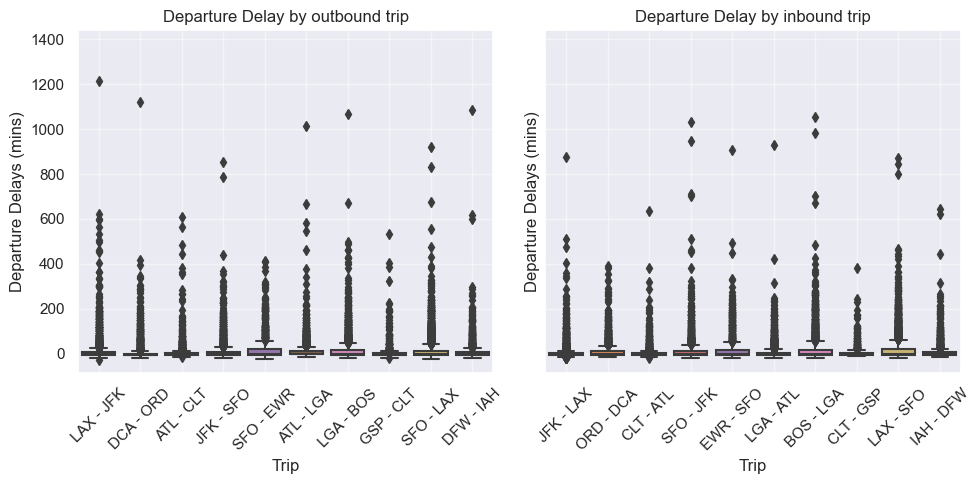

In [206]:
# Define the desired order of the x-axis categories as the top ten profitable routes 
temp_top_ten = top_ten.reset_index()[['ORIGIN','DESTINATION','TOTAL_PROF']]
                      
temp_top_ten['ROUTE'] = temp_top_ten['ORIGIN'] + ' - ' + temp_top_ten['DESTINATION']
route_order = temp_top_ten.sort_values(by = 'TOTAL_PROF', ascending = False)['ROUTE'].unique()

route_order_outbound = route_order

route_order_inbound = ['JFK - LAX', 
                       'ORD - DCA', 
                       'CLT - ATL', 
                       'SFO - JFK', 
                       'EWR - SFO', 
                       'LGA - ATL',
                       'BOS - LGA',
                       'CLT - GSP',
                       'LAX - SFO',
                       'IAH - DFW'
                      ]

# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.set_style('darkgrid')


# First subplot - outbound trip
sns.boxplot(data = fl_delay_outbound, x='ROUTE', y='DEP_DELAY', order = route_order_outbound, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[0].set_xlabel('Trip')
axs[0].set_ylabel('Departure Delays (mins)')
axs[0].set_title('Departure Delay by outbound trip')
axs[0].set_ylim(top = 1440) 
axs[0].grid(visible = True, alpha = 0.5)

# Second subplot - inbound trip with specified ordering
sns.boxplot(data = fl_delay_inbound, x='ROUTE', y='DEP_DELAY', order = route_order_inbound, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
axs[1].set_xlabel('Trip')
axs[1].set_ylabel('Departure Delays (mins)')
axs[1].set_title('Departure Delay by inbound trip')
axs[1].set_ylim(top = 1440) 
axs[1].grid(visible = True, alpha = 0.5)


# Adjust spacing between subplots
plt.tight_layout()

#Export the figure 
plt.savefig('Departure_Delay_per_leg.png', dpi = 600)

# Display the plots
plt.show()

### Cost Analysis 
We will investigate why certain routes bigger total costs than others in the "top ten profitable routes" table. We will break down the overall cost to its constituents.

#### Total Operational Costs 

In [184]:
fl_OPCOST = flights_aircodes[['ORIGIN', 'DESTINATION', 'OP_COST', 'TYPE']]

In [185]:
#Aggregate operation costs per flight
fl_TOTAL_OPCOST = (fl_OPCOST.groupby(['ORIGIN','DESTINATION'])[['OP_COST']]
                            .sum()
                            .rename(columns = {'OP_COST': 'TOTAL_OP_COST'})
                  )

In [186]:
#Self-join to match the legs of each route 
df_temp = fl_TOTAL_OPCOST.copy().reset_index()

fl_TOTAL_OPCOST_routes = pd.merge(df_temp,
                         df_temp,
                         left_on=['ORIGIN', 'DESTINATION'],
                         right_on=['DESTINATION', 'ORIGIN'],
                         suffixes=('_outbound', '_inbound')
                        )

fl_TOTAL_OPCOST_routes['TOTAL_OP_COST'] = fl_TOTAL_OPCOST_routes['TOTAL_OP_COST_inbound'] + fl_TOTAL_OPCOST_routes['TOTAL_OP_COST_outbound']

In [187]:
#Join the total operation cost table with the top ten routes table
top_ten_no_index = top_ten.copy().reset_index() 

top_ten_OPCOST = (pd.merge(fl_TOTAL_OPCOST_routes,
                              top_ten_no_index,
                              left_on = ['ORIGIN_outbound','DESTINATION_outbound'],
                              right_on = ['ORIGIN', 'DESTINATION']
                              )
                        .set_index(['ORIGIN', 'DESTINATION'])
                  )

In [188]:
top_ten_show_OPCOST = top_ten_OPCOST[['TOTAL_COST','TOTAL_PROF','TOTAL_OP_COST']]

#Set the style 
(top_ten_show_OPCOST.sort_values(by = 'TOTAL_PROF', ascending = False)
                    .style.format({
                       'TOTAL_REV': eng_fmt,
                       'TOTAL_COST': eng_fmt, 
                       'TOTAL_PROF': eng_fmt,
                       'TOTAL_OP_COST':eng_fmt
                     }).background_gradient()
)

,,TOTAL_COST,TOTAL_PROF,TOTAL_OP_COST
ORIGIN,DESTINATION,,,
LAX,JFK,214.95M,311.69M,63.20M
DCA,ORD,64.08M,166.82M,36.95M
ATL,CLT,39.85M,165.18M,30.76M
JFK,SFO,133.65M,157.95M,37.21M
SFO,EWR,88.23M,144.56M,24.24M
ATL,LGA,84.90M,140.73M,45.94M
LGA,BOS,70.34M,137.84M,48.20M
GSP,CLT,18.08M,135.43M,15.47M
SFO,LAX,131.27M,134.61M,83.40M


JFK -> SFO route has lower total operation cost. This is directly a result number of flights in that route.

We continue with calculating FOM and DIO costs per route

In [189]:
fl_OTHER_COST = flights_aircodes[['ORIGIN', 'DESTINATION', 'FOMC_Cost', 'DIO_Cost','TYPE']]

In [190]:
#Aggregate FOM and DIO costs per flight
fl_TOTAL_OTHER_COST = (fl_OTHER_COST.groupby(['ORIGIN','DESTINATION'])[['FOMC_Cost','DIO_Cost']]
                        .sum()
                        .rename(columns = {'FOMC_Cost': 'TOTAL_FOMC', 'DIO_Cost': 'TOTAL_DIO_COST'})
                      )

In [191]:
#Self-join to match the legs of each route 
df_temp = fl_TOTAL_OTHER_COST.copy().reset_index()

fl_TOTAL_OTHER_COST_routes = pd.merge(df_temp,
                                      df_temp,
                                      left_on=['ORIGIN', 'DESTINATION'],
                                      right_on=['DESTINATION', 'ORIGIN'],
                                      suffixes=('_outbound', '_inbound')
                                    )

fl_TOTAL_OTHER_COST_routes['TOTAL_FOMC'] = fl_TOTAL_OTHER_COST_routes['TOTAL_FOMC_inbound'] + fl_TOTAL_OTHER_COST_routes['TOTAL_FOMC_outbound']
fl_TOTAL_OTHER_COST_routes['TOTAL_DIO'] = fl_TOTAL_OTHER_COST_routes['TOTAL_DIO_COST_inbound'] + fl_TOTAL_OTHER_COST_routes['TOTAL_DIO_COST_outbound']

In [192]:
#Join the other costs table with the top ten routes table that includes operational costs 
top_ten_no_index = top_ten_OPCOST.copy().reset_index() 

top_ten_OTHER_COSTS = (pd.merge(fl_TOTAL_OTHER_COST_routes,
                                top_ten_no_index,
                                left_on = ['ORIGIN_outbound','DESTINATION_outbound'],
                                right_on = ['ORIGIN', 'DESTINATION']
                                )
                         .set_index(['ORIGIN', 'DESTINATION'])
                       )

In [193]:
#Show the final table 
top_ten_show_OTHER_COSTS = top_ten_OTHER_COSTS[['TOTAL_COST','TOTAL_PROF','TOTAL_OP_COST','TOTAL_FOMC','TOTAL_DIO']]

#Set the style 
(top_ten_show_OTHER_COSTS.sort_values(by = 'TOTAL_PROF', ascending = False)
                         .style.format({
                          'TOTAL_REV': eng_fmt,
                          'TOTAL_COST': eng_fmt, 
                          'TOTAL_PROF': eng_fmt,
                          'TOTAL_OP_COST':eng_fmt,
                          'TOTAL_FOMC': eng_fmt, 
                          'TOTAL_DIO': eng_fmt      
                     }).background_gradient()
)

,,TOTAL_COST,TOTAL_PROF,TOTAL_OP_COST,TOTAL_FOMC,TOTAL_DIO
ORIGIN,DESTINATION,,,,,
LAX,JFK,214.95M,311.69M,63.20M,125.14M,18.46M
DCA,ORD,64.08M,166.82M,36.95M,18.09M,2.67M
ATL,CLT,39.85M,165.18M,30.76M,5.56M,820.31k
JFK,SFO,133.65M,157.95M,37.21M,76.98M,11.35M
SFO,EWR,88.23M,144.56M,24.24M,49.74M,7.34M
ATL,LGA,84.90M,140.73M,45.94M,28.01M,4.13M
LGA,BOS,70.34M,137.84M,48.20M,7.10M,1.05M
GSP,CLT,18.08M,135.43M,15.47M,928.20k,136.91k
SFO,LAX,131.27M,134.61M,83.40M,22.48M,3.32M


We will add the delay costs and see the complete picture about how the costs are shared across different factors. 

In [194]:
fl_DELAY_COST = flights_aircodes[['ORIGIN','DESTINATION','DEP_DEL_COST','ARR_DEL_COST', 'TYPE']]

#Aggregate arrival and departure delay costs per flight
fl_TOTAL_DELAY_COST = (fl_DELAY_COST.groupby(['ORIGIN','DESTINATION'])[['DEP_DEL_COST','ARR_DEL_COST']]
                                    .sum()
                                    .rename(columns = {'DEP_DEL_COST': 'TOTAL_DEP_DEL_COST', 'ARR_DEL_COST': 'TOTAL_ARR_DEL_COST'})
                      )

In [195]:
#Self-join to match the legs of each route 
df_temp = fl_TOTAL_DELAY_COST.copy().reset_index()

fl_TOTAL_DELAY_COST_routes = pd.merge(df_temp,
                                      df_temp,
                                      left_on=['ORIGIN', 'DESTINATION'],
                                      right_on=['DESTINATION', 'ORIGIN'],
                                      suffixes=('_outbound', '_inbound')
                                    )

fl_TOTAL_DELAY_COST_routes['TOTAL_DEP_DEL_COST'] = fl_TOTAL_DELAY_COST_routes['TOTAL_DEP_DEL_COST_inbound'] + fl_TOTAL_DELAY_COST_routes['TOTAL_DEP_DEL_COST_outbound']
fl_TOTAL_DELAY_COST_routes['TOTAL_ARR_DEL_COST'] = fl_TOTAL_DELAY_COST_routes['TOTAL_ARR_DEL_COST_inbound'] + fl_TOTAL_DELAY_COST_routes['TOTAL_ARR_DEL_COST_outbound']



In [196]:
#Join the other costs table with the top ten routes table that includes operational costs 
top_ten_no_index = top_ten_show_OTHER_COSTS.copy().reset_index() 

top_ten_DELAY_COSTS = (pd.merge(fl_TOTAL_DELAY_COST_routes,
                                top_ten_no_index,
                                left_on = ['ORIGIN_outbound','DESTINATION_outbound'],
                                right_on = ['ORIGIN', 'DESTINATION']
                                )
                         .set_index(['ORIGIN', 'DESTINATION'])
                       )

In [197]:
#Show the final table 
top_ten_show_DELAY_COSTS = top_ten_DELAY_COSTS[['TOTAL_COST',
                                                'TOTAL_PROF',
                                                'TOTAL_OP_COST',
                                                'TOTAL_FOMC',
                                                'TOTAL_DIO',
                                                'TOTAL_DEP_DEL_COST',
                                                'TOTAL_ARR_DEL_COST']]

#Set the style 
(top_ten_show_DELAY_COSTS.sort_values(by = 'TOTAL_PROF', ascending = False)
                         .style.format({
                          'TOTAL_REV': eng_fmt,
                          'TOTAL_COST': eng_fmt, 
                          'TOTAL_PROF': eng_fmt,
                          'TOTAL_OP_COST':eng_fmt,
                          'TOTAL_FOMC': eng_fmt, 
                          'TOTAL_DIO': eng_fmt,
                          'TOTAL_DEP_DEL_COST': eng_fmt,
                          'TOTAL_ARR_DEL_COST': eng_fmt   
                     }).background_gradient()
)

,,TOTAL_COST,TOTAL_PROF,TOTAL_OP_COST,TOTAL_FOMC,TOTAL_DIO,TOTAL_DEP_DEL_COST,TOTAL_ARR_DEL_COST
ORIGIN,DESTINATION,,,,,,,
LAX,JFK,214.95M,311.69M,63.20M,125.14M,18.46M,4.05M,4.10M
DCA,ORD,64.08M,166.82M,36.95M,18.09M,2.67M,3.05M,3.32M
ATL,CLT,39.85M,165.18M,30.76M,5.56M,820.31k,1.38M,1.33M
JFK,SFO,133.65M,157.95M,37.21M,76.98M,11.35M,4.02M,4.08M
SFO,EWR,88.23M,144.56M,24.24M,49.74M,7.34M,3.45M,3.46M
ATL,LGA,84.90M,140.73M,45.94M,28.01M,4.13M,3.32M,3.50M
LGA,BOS,70.34M,137.84M,48.20M,7.10M,1.05M,6.84M,7.16M
GSP,CLT,18.08M,135.43M,15.47M,928.20k,136.91k,817.95k,729.08k
SFO,LAX,131.27M,134.61M,83.40M,22.48M,3.32M,10.52M,11.55M


Bar-plot aggregated costs per route.

In [198]:
top_ten_cost_bar = top_ten_show_DELAY_COSTS.copy().reset_index() 

top_ten_cost_bar['ROUTE'] = top_ten_cost_bar['ORIGIN'] + ' - ' + top_ten_cost_bar['DESTINATION']

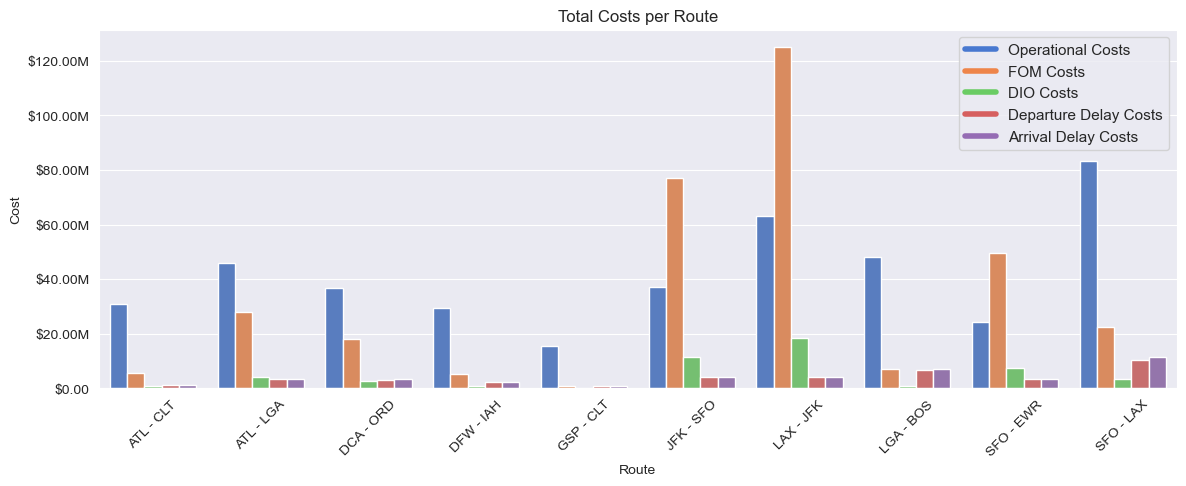

In [199]:
import matplotlib.ticker as ticker

# Create a new DataFrame with the desired columns
cost_data = top_ten_cost_bar[['ROUTE', 
                              'TOTAL_OP_COST', 
                              'TOTAL_FOMC',
                              'TOTAL_DIO',
                              'TOTAL_DEP_DEL_COST',
                             'TOTAL_ARR_DEL_COST']]

# Melt the DataFrame to convert the cost categories into a single column
melted_data = cost_data.melt('ROUTE', var_name = 'Cost', value_name = 'Value')

# Set the cost categories 
categories = ['Operational Costs', 
              'FOM Costs', 
              'DIO Costs', 
              'Departure Delay Costs',
              'Arrival Delay Costs'
             ] #melted_data['Cost'].unique()

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 5))

#Set the figure's Seaborn style
sns.set_style("darkgrid")

sns.set_context('notebook')  # Set the font size for a notebook-style plot
#sns.set(font_scale = 1)

# Set the color palette
sns.set_palette("muted")


# Plot the grouped bar plot
sns.barplot(data=melted_data, x='ROUTE', y='Value', hue='Cost', ax=ax)

# Create a custom legend with different colors for each category
legend_handles = []
for category in categories:
    color = sns.color_palette()[categories.index(category)]
    legend_handles.append(plt.Line2D([0], [0], color = color, lw=4))

# Add labels and titles
plt.xlabel('Route')
plt.ylabel('Cost')
plt.title('Total Costs per Route')


# Define a custom formatter function
def eng_dollar_formatter(x, pos):
    if x >= 1000:
        value = '${:.2f}{}'.format(x / 1e6, 'M')
    else:
        value = '${:.2f}'.format(x)
    return value

# Set the y-axis tick label formatter
ax = plt.gca()
formatter = ticker.FuncFormatter(eng_dollar_formatter)
ax.yaxis.set_major_formatter(formatter)


#Modify the legend 
plt.legend(legend_handles, categories)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout(pad=1.0)  # Adjust the padding around the figure

#Export the figure 
plt.savefig('Total_cost_breakdown_per_route.png', dpi = 600)

# Show the plot
plt.show()

In [200]:
route_flight_volume('DCA','ORD')

3695

### Quality control section

In [201]:
# # create dummy dataframes
# df1 = pd.DataFrame({'Col1' : list(range(100))})
# df2 = pd.DataFrame({'Col1' : list(range(100))})

# # check whether all variables in scope are pandas dataframe. 
# # Dir() will return a list of string representations of the variables. 
# # Simply evaluate and test whether they are pandas dataframes
# alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]

# print(alldfs) # df1, df2

In [202]:
top_ten

MEAN_AIR_TIME  TOTAL_REV  TOTAL_COST  TOTAL_PROF  \
ORIGIN DESTINATION                                                     
ATL    CLT                  88.05    205.03M      39.85M     165.18M   
       LGA                 220.28    225.63M      84.90M     140.73M   
DCA    ORD                 185.21    230.90M      64.08M     166.82M   
DFW    IAH                  88.78    174.37M      40.25M     134.12M   
GSP    CLT                  47.82    153.51M      18.08M     135.43M   
JFK    SFO                 655.12    291.60M     133.65M     157.95M   
LAX    JFK                 630.50    526.64M     214.95M     311.69M   
LGA    BOS                  86.09    208.19M      70.34M     137.84M   
SFO    EWR                 632.37    232.79M      88.23M     144.56M   
       LAX                 113.95    265.88M     131.27M     134.61M   

                    PROF_MARGIN  ROI_multiple  DEP_PUNC  MEAN_PASSENGER  \
ORIGIN DESTINATION                                                        
ATL    CLT              805.63m          4.14   881.66m          129.77   
       LGA              623.74m          1.66   801.70m          130.22   
DCA    ORD              722.46m          2.60   819.76m          129.58   
DFW    IAH              769.19m          3.33   824.03m          130.19   
GSP    CLT              882.21m          7.49   866.84m          129.92   
JFK    SFO              541.68m          1.18   779.63m          129.97   
LAX    JFK              591.85m          1.45   852.37m          130.01   
LGA    BOS              662.12m          1.96   747.72m          130.17   
SFO    EWR              621.00m          1.64   727.31m          129.98   
       LAX              506.30m          1.03   736.93m          129.80   

                    MEAN_RPM  
ORIGIN DESTINATION            
ATL    CLT            29.33k  
       LGA            99.23k  
DCA    ORD            79.31k  
DFW    IAH            29.16k  
GSP    CLT             9.74k  
JFK    SFO           336.10k  
LAX    JFK           321.79k  
LGA    BOS            23.95k  
SFO    EWR           333.40k  
       LAX            43.74k

In [ ]:
fl_avg_fare.info()

In [ ]:
(top_ten_show_DELAY_COSTS['TOTAL_OP_COST'] 
 + top_ten_show_DELAY_COSTS['TOTAL_FOMC'] 
 + top_ten_show_DELAY_COSTS['TOTAL_DIO'] 
 + top_ten_show_DELAY_COSTS['TOTAL_DEP_DEL_COST'] 
 + top_ten_show_DELAY_COSTS['TOTAL_ARR_DEL_COST']  
) #== top_ten_show_DELAY_COSTS['TOTAL_COST']

In [ ]:
#Check if the ratio between FOMC and DIO cost is equal to $8/$1.18 
(top_ten_show_OTHER_COSTS['TOTAL_FOMC'] /top_ten_show_OTHER_COSTS['TOTAL_DIO']) 

In [ ]:
#Check the number of flights for a particular route 
check = (fl_OPCOST.ORIGIN == 'JFK') & (fl_OPCOST.DESTINATION == 'SFO')
fl_OPCOST[check].OP_COST.count()

check = (flights_aircodes.ORIGIN == 'LAX') & (flights_aircodes.DESTINATION == 'SFO')
flights_aircodes[check].count()

In [ ]:
#Check if there are any small airport or heliport in this subset 

subset = flights_aircodes[['ORIGIN', 'DESTINATION', 'OP_COST', 'TYPE']]
subset[~((subset.TYPE == 'medium_airport') | (subset.TYPE == 'large_airport')) & ~subset.OP_COST.isna()]

In [ ]:
flights_aircodes[['ORIGIN', 'DESTINATION', 'DISTANCE', 'AIR_TIME']].tail(10)

In [ ]:
routes_ranked[['ORIGIN_outbound', 
               'ORIGIN_inbound',
               'TOTAL_REV_inbound', 
               'TOTAL_REV_outbound']].head(10)

In [ ]:
routes_ranked[['ORIGIN_outbound', 
               'ORIGIN_inbound',
               'TOTAL_COST_inbound', 
               'TOTAL_COST_outbound']].head(10)

In [ ]:
tickets_subset = tickets[(tickets['ORIGIN'] == 'ATL') & 
                         (tickets['DESTINATION'] == 'CLT')
                        ][['ORIGIN', 'DESTINATION', 'ITIN_FARE', 'PASSENGERS', 'TOTAL_FARE']]

In [ ]:
tickets_subset.sort_values(by = 'ITIN_FARE', ascending = False).head(10)

In [ ]:
check_tickets = agg_tickets_all.reset_index()

In [ ]:
check_tickets[(check_tickets['ORIGIN'] ==  'ATL') & (check_tickets['DESTINATION'] == 'CLT')] 

In [ ]:
check_tickets[(check_tickets['ORIGIN'] ==  'CLT') & (check_tickets['DESTINATION'] == 'ATL')] 

Check if any of the listed routes in Q2 is a small airport. 

### Code Junkyard 

In [ ]:
# fl_fare['ROUTE'] = np.where(((fl_fare['ORIGIN'] == 'LAX') & (fl_fare['DESTINATION'] == 'JFK')) | ((fl_fare['ORIGIN'] == 'JFK') & (fl_fare['DESTINATION'] == 'LAX')),
#                        'LAX - JFK', 
#                        fl_fare['ORIGIN'] + ' - ' + fl_fare['DESTINATION'])

In [ ]:
#Fix the format of all entries to engineering. You can change this later. 
#pd.set_eng_float_format(accuracy = 2, use_eng_prefix=True)

In [ ]:
# sns.set_style('darkgrid')

# # Adjust the figure size
# g = sns.catplot(data = top_ten_cost_bar, x='ROUTE', y = 'TOTAL_COST', 
#                 #hue = 'TOTAL_FOMC',
#                 kind = 'bar', 
#                 height = 5, 
#                 aspect = 2
#                )
# g.set_xticklabels(rotation=45)

# # Adjust the grid appearance
# plt.grid(alpha = 0.5)

# # Display the plot
# plt.show()

In [ ]:
#test.sort_values(by = 'DISTANCE', ascending = False)

In [ ]:
# airport_codes_file = 'Airport_Codes.csv' 
# flights_file = 'Flights.csv'
# tickets_file = 'Tickets.csv'

# #Load and cast the data to Pandas DataFrame 
# air_codes = pd.read_csv(r'' + Home + airport_codes_file) 
# flights = pd.read_csv(r'' + Home + flights_file)
# tickets = pd.read_csv(r'' + Home + tickets_file)

In [ ]:
#Check the floating number after the decimal point. 
#digit_finder = lambda x: isinstance(x, int) if x.isdigit() else print(x) 
#int_finder = lambda x: (float(x) % 1) == 0.0 if not pd.isnull(x) else x
#tickets.PASSENGERS.apply(int_finder)

In [ ]:
# check_digits = lambda x: x.isdigit()

# tickets_nonull = tickets[~tickets.ITIN_FARE.isnull()] 
# log_mask = ~tickets_nonull.ITIN_FARE.apply(check_digits)

In [ ]:
# routes_general = tickets.groupby(['ORIGIN','DESTINATION'], as_index = False)
# profitables_routes = routes_general['ITIN_FARE'].sum()
# profitables_routes.sort_values(by = 'ITIN_FARE', ascending = False).head(20) 
# tickets.head(1)

In [ ]:
# flights_aircodes['OP_COST'] = np.where(flights_aircodes.TYPE == 'large_airport', 10000, 5000)

In [ ]:
# (flights_aircodes.groupby(['ORIGIN','DESTINATION'])[['BAGGAGE_FARE']]
#                 .sum()
#                 .sort_values(by = 'BAGGAGE_FARE', ascending = False)
#                 .head(10)
# )

In [ ]:
# tickets_subset = tickets[(tickets['ORIGIN'] == 'PHL') &  (tickets['DESTINATION'] == 'SWF')]
# tickets_subset[['ORIGIN', 'DESTINATION', 'ITIN_FARE', 'PASSENGERS', 'TOTAL_FARE']]

# flights_aircodes_subset = flights_aircodes[(flights_aircodes['ORIGIN'] == 'PHL') & (flights_aircodes['DESTINATION'] == 'SWF')] 
# flights_aircodes_subset[['ORIGIN', 'DESTINATION','OCCUPANCY_RATE', 'FL_DATE']]

In [ ]:
#tickets_subset = tickets[(tickets['ORIGIN'] == 'SFO') & (tickets['DESTINATION'] == 'LAX')][['ORIGIN', 'DESTINATION', 'ITIN_FARE', 'PASSENGERS', 'TOTAL_FARE']]
#tickets_subset.sort_values(by = 'PASSENGERS', ascending = False)


In [ ]:
#tickets_subset.sort_values(by = 'PASSENGERS', ascending = False)
#tickets_subset.shape

See. The number of ticketed itineraies is scarce compared to the number of flights listed in the flights table for the route.

This is normal as I figured later. The tickets is not a complete dataset! Only samples, 

*Ticket prices data (randomly sampled data only as the original dataset data is huge)*

Check if the SFO-LAX route has something peculiar.

In [ ]:
# baggage_subset = flights_aircodes[(flights_aircodes['ORIGIN'] == 'SFO') & (flights_aircodes['DESTINATION'] == 'LAX')][['ORIGIN', 
#                                                                                                       'DESTINATION', 
#                                                                                                       'BAGGAGE_FARE', 
#                                                                                                       'OCCUPANCY_RATE'
#                                                                                                     ]]

In [ ]:
# baggage_subset.head(10)

In [ ]:
#baggage_subset.groupby(['ORIGIN','DESTINATION'])[['BAGGAGE_FARE']].sum()

Nope. The gross baggage fees is 17 times bigger than the gross itineary fares for the SFO-LAX route. The baggage fares of the round trip was not included!!!

In [ ]:
# #Drop repeated rows 
# index_array = np.array([])

# for i,j in enumerate(round_trip_df['ORIGIN_outbound']):
#     search_mask = round_trip_df['DESTINATION_outbound'] == j
#     if search_mask.any():
#         new_mask = round_trip_df['DESTINATION_outbound'][i] == round_trip_df['ORIGIN_outbound'][search_mask]
#         np.append(index_array, round_trip_df[['ORIGIN_outbound','DESTINATION_outbound']][new_mask & search_mask].index)
#          #round_trip_df['DESTINATION_outbound'][i] == round_trip_df['ORIGIN_outbound'][search_mask]:
#                 # print(round_trip_df[['ORIGIN_outbound', 'DESTINATION_outbound']][i])
#                 # print(round_trip_df[['ORIGIN_outbound', 'DESTINATION_outbound']][search_mask])


In [ ]:
# tuples = list(zip(list(new_routes['ORIGIN']), 
#                        list(new_routes['DESTINATION']), 
#                        list(new_routes['count'])
#                       )
#              )

In [ ]:
# new_list = [] 
# for u,v,c in tuples: 
#     #print(v)
#     #check if u(0) == v(1,...) 
#     names_forward = [u == j for i,j,k in tuples]
#     names_backward = [v == i for i,j,k in tuples]
#     #Match the True values 
#     mask = np.array([x & y for x, y in zip(names_forward, names_backward)]) 
#     tuples_np = np.array(tuples) 
    
#     #Find the total number of inbound flights and finalize the
#     bound_flight = tuples_np[mask]
#     total_number = int(c) + int(tuples_np[mask].flatten()[-1])
#     new_list.append(tuple((u,v,total_number)))
 
# final_list = [j for i,j in enumerate(new_list) if i % 2 == 0]

In [ ]:
# fl_meanp_merged.sort_values(by = 'MEAN_PASS_outbound', ascending = False)[['ORIGIN_outbound',
#                                                                        'DESTINATION_outbound',
#                                                                        'MEAN_PASS_outbound'
#                                                                       ]].head(20) 

In [ ]:
# # Create the figure and axes
# fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# #fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.0, 1.0]})
# #fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'wspace': 0.4, 'width_ratios': [1.0, 1.0]})

# # Adjust the spacing between subplots
# plt.subplots_adjust(hspace = 0.9)

# # First subplot - outbound trip
# sns.boxplot(data = fl_delay_outbound, x = 'ROUTE', y = 'DEP_DELAY', ax = axs[0])
# axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 45)
# #axs[0].rotate 
# axs[0].set_xlabel('Trip')
# axs[0].set_ylabel('Departure Delays (mins)')
# axs[0].set_title('Departure Delay by outbound trip')

# # Second subplot - inbound trip
# sns.boxplot(data=fl_delay_inbound, x = 'ROUTE', y = 'DEP_DELAY', ax = axs[1])
# axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
# axs[1].set_xlabel('Trip')
# axs[1].set_ylabel('Departure Delays (mins)')
# axs[1].set_title('Departure Delay by inbound trip')

# # Adjust spacing between subplots
# plt.tight_layout(pad = 1.0)

# # Display the plots
# plt.show()